In [1]:
import matplotlib.pyplot as plt
import torch
import os
from pathlib import Path
from importlib import reload

os.chdir("..")  # Change root dir to project folder
os.getcwd()

'/home/bbd0953/diffusion/src'

# Compare Model and LOFAR Map

In [2]:
from astropy.io import fits
from astropy.wcs import WCS


def get_image(file, get_wcs=True):
    hdul = fits.open(file)
    image = hdul[0].data
    if get_wcs:
        wcs = WCS(hdul[0].header, naxis=2)
        return image, wcs
    else:
        return image

In [20]:
map_folder = Path("/home/bbd0953/diffusion/sky_maps/test_map_80")
sky_model_file = map_folder / "test_map_80.fits"
image_file = map_folder / "ddf-pipeline/image_dirin_SSD_m_c_di_m.app.restored.fits"

model_arr, model_wcs = get_image(sky_model_file)
image_arr, image_wcs = get_image(image_file)

(<Figure size 1200x600 with 3 Axes>,
 array([<WCSAxes: >, <WCSAxes: >], dtype=object))

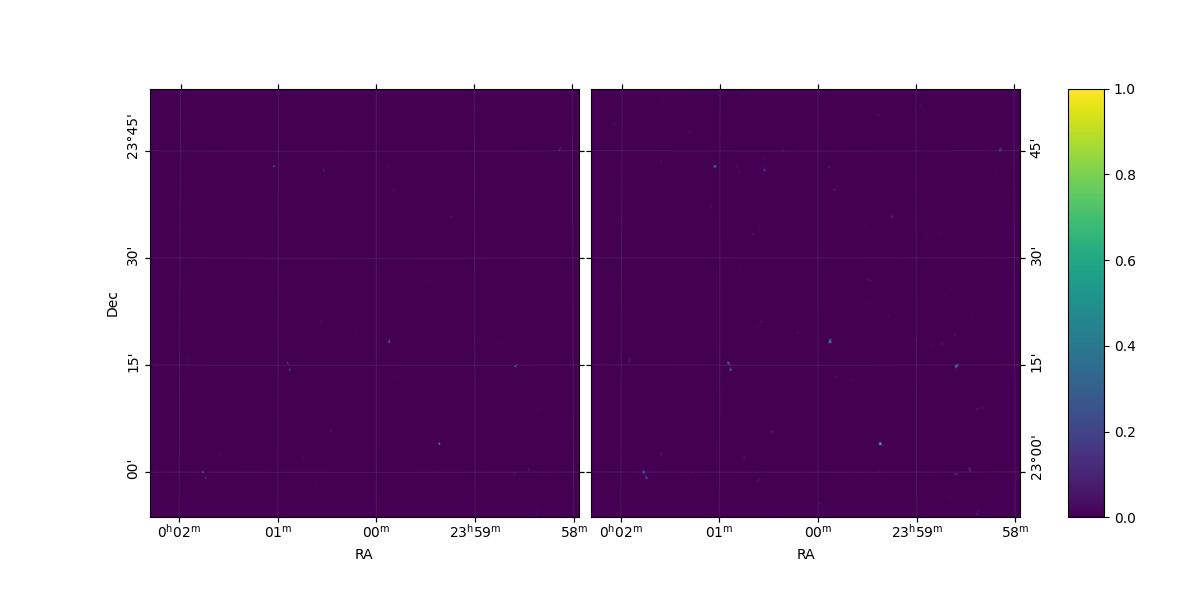

In [21]:
import plotting.map_plots as mpplt
reload(mpplt)

%matplotlib widget
mpplt.double_map_plot(
    model_arr,
    image_arr,
    wcs=(model_wcs, image_wcs),
    scale_fn = lambda x: x,
    size=(12, 6),
    minmax=True,
)

(<Figure size 600x600 with 2 Axes>,
 <WCSAxes: >,
 <matplotlib.image.AxesImage at 0x7f85f3b9f2d0>)

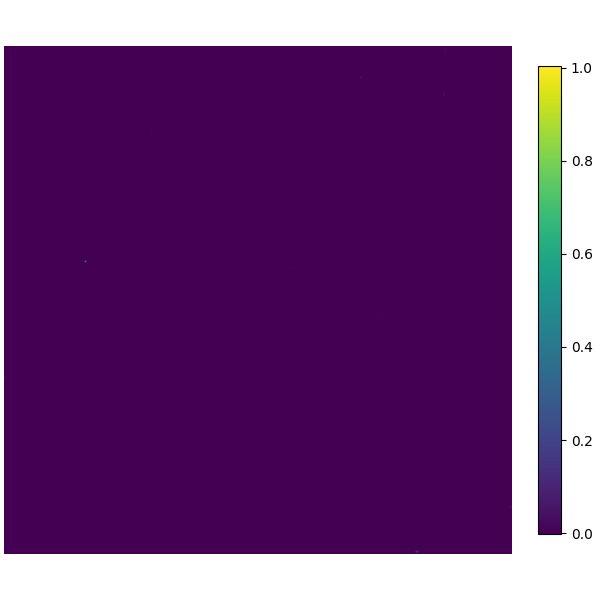

/hs/fs08/data/group-brueggen/tmartinez/envs/cenv_diffusion/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.manager.handle_json(content)
/hs/fs08/data/group-brueggen/tmartinez/envs/cenv_diffusion/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.manager.handle_json(content)


In [7]:
import utils.paths as paths
import plotting.map_plots as mpplt
reload(mpplt)
import numpy as np

lotss_file = paths.MOSAIC_DIR / "P202+42/mosaic-blanked.fits"
lotss_arr, lotss_wcs = get_image(lotss_file)

# Center cutout of 2400x2400 px, initially it is 9320 px
N = lotss_arr.squeeze().shape[0]
n1 = (N - 2400) // 2
n2 = n1 + 2400
lotss_arr = lotss_arr[n1:n2, n1:n2]
lotss_arr = np.clip(lotss_arr, -0.0015, lotss_arr.max())

%matplotlib widget
mpplt.plot_sky_map(
    lotss_arr, 
    wcs=lotss_wcs, 
    scale_fn=lambda x: x,
    size=(6, 6),
)

In [8]:
lotss_arr.shape

(2400, 2400)

Look at Dirty Image / PSF:

(<Figure size 900x900 with 2 Axes>,
 <WCSAxes: >,
 <matplotlib.image.AxesImage at 0x7f3d9a02e610>)

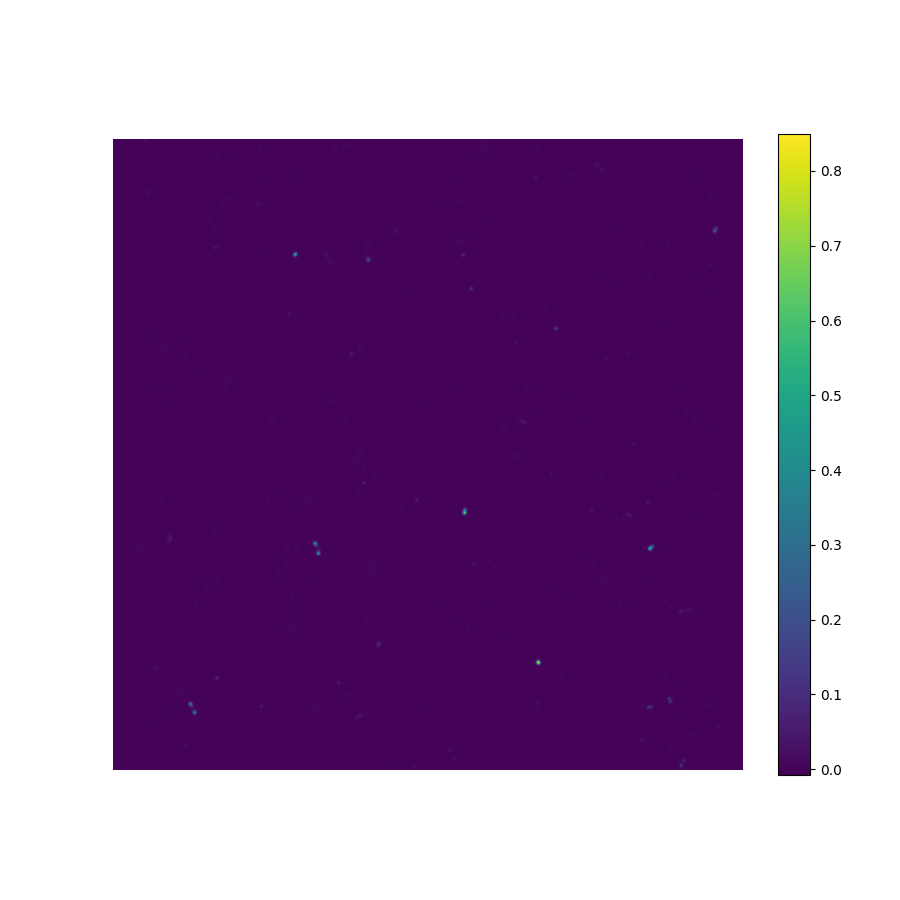

In [6]:
import plotting.map_plots as mpplt
reload(mpplt)

# file = map_folder / "ddf/test_map_80_ddf.dirty.fits"
file = '/hs/fs08/data/group-brueggen/tmartinez/sky_maps/test_map_80/ddf-pipeline/image_dirin_SSD_m.app.restored.fits'

dirty_arr, dirty_wcs = get_image(file)

%matplotlib widget
mpplt.plot_sky_map(dirty_arr, wcs=dirty_wcs)

# Plot uv-coverage

In [22]:
import glob
import sys
import numpy as np
import casacore.tables as pt
from tqdm import tqdm


def get_uv_figax(MS):

    match MS:
        case str():
            MSlist = [MS]
        case Path():
            MSlist = [str(MS)]
        case list():
            MSlist = MS

    timeslots = [0, 0, 0]  # start, skip, end (default all)
    antToPlot = [-1]  # default all

    badval = 0.0
    xaxisvals0 = np.array([])
    yaxisvals0 = np.array([])
    xaxisvals1 = np.array([])
    yaxisvals1 = np.array([])
    xaxisvals2 = np.array([])
    yaxisvals2 = np.array([])
    xaxisvals3 = np.array([])
    yaxisvals3 = np.array([])
    xaxisvals4 = np.array([])
    yaxisvals4 = np.array([])
    xaxisvals5 = np.array([])
    yaxisvals5 = np.array([])
    savex0 = np.array([])
    savey0 = np.array([])
    savex1 = np.array([])
    savey1 = np.array([])
    savex2 = np.array([])
    savey2 = np.array([])
    savex3 = np.array([])
    savey3 = np.array([])
    savex4 = np.array([])
    savey4 = np.array([])
    savex5 = np.array([])
    savey5 = np.array([])

    numPlotted = 0
    ptcolor = 0
    for inputMS in MSlist:
        # open the main table and print some info about the MS
        print("Getting info for", inputMS)
        t = pt.table(inputMS, readonly=True, ack=False)
        tfreq = pt.table(t.getkeyword("SPECTRAL_WINDOW"), readonly=True, ack=False)
        ref_freq = tfreq.getcol("REF_FREQUENCY", nrow=1)[0]
        ch_freq = tfreq.getcol("CHAN_FREQ", nrow=1)[0]
        print("Reference frequency:\t%f MHz" % (ref_freq / 1.0e6))
        ref_wavelength = [2.99792458e8 / ref_freq]
        print("Reference wavelength:\t%f m" % (ref_wavelength[0]))
        firstTime = t.getcell("TIME", 0)
        lastTime = t.getcell("TIME", t.nrows() - 1)
        intTime = t.getcell("INTERVAL", 0)
        print("Integration time:\t%f sec" % (intTime))
        nTimeslots = (lastTime - firstTime) / intTime
        print("Number of timeslots:\t%d" % (nTimeslots))
        if timeslots[1] == 0:
            if nTimeslots >= 100:
                timeskip = int(nTimeslots / 100)
            else:
                timeskip = 1
        else:
            timeskip = int(timeslots[1])
        print("For each baseline, plotting one point every %d samples" % (timeskip))
        if timeslots[2] == 0:
            timeslots[2] = nTimeslots
        # open the antenna subtable
        tant = pt.table(t.getkeyword("ANTENNA"), readonly=True, ack=False)

        # Station names
        antList = tant.getcol("NAME")
        if len(antToPlot) == 1 and antToPlot[0] == -1:
            antToPlot = list(range(len(antList)))
        print("Station list (only starred stations will be plotted):")
        for i in range(len(antList)):
            star = " "
            if i in antToPlot:
                star = "*"
            print("%s %2d\t%s" % (star, i, antList[i]))

        # select by time from the beginning, and only use specified antennas
        tsel = t.query(
            "TIME >= %f AND TIME <= %f AND ANTENNA1 IN %s AND ANTENNA2 IN %s"
            % (
                firstTime + timeslots[0] * intTime,
                firstTime + timeslots[2] * intTime,
                str(antToPlot),
                str(antToPlot),
            ),
            columns="ANTENNA1,ANTENNA2,UVW",
        )

        # Now we loop through the baselines
        i = 0
        nb = (len(antToPlot) * (len(antToPlot) - 1)) / 2
        print("Reading uvw for %d baselines: %04d/%04d" % (nb, i, nb))

        for tpart in tqdm(tsel.iter(["ANTENNA1", "ANTENNA2"]), total=nb):
            ant1 = tpart.getcell("ANTENNA1", 0)
            ant2 = tpart.getcell("ANTENNA2", 0)
            if ant1 not in antToPlot or ant2 not in antToPlot:
                continue
            if ant1 == ant2:
                continue
            i += 1

            # Get the values to plot
            uvw = tpart.getcol("UVW", rowincr=timeskip)
            if numPlotted == 0:
                savex0 = np.append(savex0, [uvw[:, 0], -uvw[:, 0]])
                savey0 = np.append(savey0, [uvw[:, 1], -uvw[:, 1]])
                savex1 = np.append(savex1, [uvw[:, 0], -uvw[:, 0]])
                savey1 = np.append(savey1, [uvw[:, 1], -uvw[:, 1]])
                savex2 = np.append(savex2, [uvw[:, 0], -uvw[:, 0]])
                savey2 = np.append(savey2, [uvw[:, 1], -uvw[:, 1]])
                savex3 = np.append(savex3, [uvw[:, 0], -uvw[:, 0]])
                savey3 = np.append(savey3, [uvw[:, 1], -uvw[:, 1]])
                savex4 = np.append(savex4, [uvw[:, 0], -uvw[:, 0]])
                savey4 = np.append(savey4, [uvw[:, 1], -uvw[:, 1]])
                savex5 = np.append(savex5, [uvw[:, 0], -uvw[:, 0]])
                savey5 = np.append(savey5, [uvw[:, 1], -uvw[:, 1]])

            if ptcolor == 0:
                xaxisvals0 = np.append(xaxisvals0, [uvw[:, 0], -uvw[:, 0]])
                yaxisvals0 = np.append(yaxisvals0, [uvw[:, 1], -uvw[:, 1]])
            elif ptcolor == 1:
                xaxisvals1 = np.append(xaxisvals1, [uvw[:, 0], -uvw[:, 0]])
                yaxisvals1 = np.append(yaxisvals1, [uvw[:, 1], -uvw[:, 1]])
            elif ptcolor == 2:
                xaxisvals2 = np.append(xaxisvals2, [uvw[:, 0], -uvw[:, 0]])
                yaxisvals2 = np.append(yaxisvals2, [uvw[:, 1], -uvw[:, 1]])
            elif ptcolor == 3:
                xaxisvals3 = np.append(xaxisvals3, [uvw[:, 0], -uvw[:, 0]])
                yaxisvals3 = np.append(yaxisvals3, [uvw[:, 1], -uvw[:, 1]])
            elif ptcolor == 4:
                xaxisvals4 = np.append(xaxisvals4, [uvw[:, 0], -uvw[:, 0]])
                yaxisvals4 = np.append(yaxisvals4, [uvw[:, 1], -uvw[:, 1]])
            elif ptcolor == 5:
                xaxisvals5 = np.append(xaxisvals5, [uvw[:, 0], -uvw[:, 0]])
                yaxisvals5 = np.append(yaxisvals5, [uvw[:, 1], -uvw[:, 1]])

        sys.stdout.write(" Done!\n")
        numPlotted += 1

    print("Plotting uv points ...")
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(nrows=1, figsize=(6, 6), sharex=True)
    fig.subplots_adjust(hspace=0)

    tmpvals0 = np.sqrt(xaxisvals0**2 + yaxisvals0**2)
    tmpvals1 = np.sqrt(xaxisvals1**2 + yaxisvals1**2)
    tmpvals2 = np.sqrt(xaxisvals2**2 + yaxisvals2**2)
    tmpvals3 = np.sqrt(xaxisvals3**2 + yaxisvals3**2)
    tmpvals4 = np.sqrt(xaxisvals4**2 + yaxisvals4**2)
    tmpvals5 = np.sqrt(xaxisvals5**2 + yaxisvals5**2)

    # Plot the data
    ax.set_xlabel("u [m]")
    ax.set_ylabel("v [m]")

    ax.plot(
        xaxisvals0[tmpvals0 != badval], yaxisvals0[tmpvals0 != badval], ",k", alpha=0.2
    )
    ax.plot(
        xaxisvals1[tmpvals1 != badval], yaxisvals1[tmpvals1 != badval], ",r", alpha=0.2
    )
    ax.plot(
        xaxisvals2[tmpvals2 != badval], yaxisvals2[tmpvals2 != badval], ",b", alpha=0.2
    )
    ax.plot(
        xaxisvals3[tmpvals3 != badval], yaxisvals3[tmpvals3 != badval], ",g", alpha=0.2
    )
    ax.plot(
        xaxisvals4[tmpvals4 != badval], yaxisvals4[tmpvals4 != badval], ",y", alpha=0.2
    )
    ax.plot(
        xaxisvals5[tmpvals5 != badval], yaxisvals5[tmpvals5 != badval], ",c", alpha=0.2
    )

    return fig, ax

Getting info for /home/bbd0953/diffusion/sky_maps/test_map_80/synthms/test_map_80_t201811301614_SBH225.MS
Reference frequency:	143.945312 MHz
Reference wavelength:	2.082683 m
Integration time:	4.005560 sec
Number of timeslots:	7189
For each baseline, plotting one point every 71 samples
Station list (only starred stations will be plotted):
*  0	CS001HBA0
*  1	CS001HBA1
*  2	CS002HBA0
*  3	CS002HBA1
*  4	CS003HBA0
*  5	CS003HBA1
*  6	CS004HBA0
*  7	CS004HBA1
*  8	CS005HBA0
*  9	CS005HBA1
* 10	CS006HBA0
* 11	CS006HBA1
* 12	CS007HBA0
* 13	CS007HBA1
* 14	CS011HBA0
* 15	CS011HBA1
* 16	CS013HBA0
* 17	CS013HBA1
* 18	CS017HBA0
* 19	CS017HBA1
* 20	CS024HBA0
* 21	CS024HBA1
* 22	CS026HBA0
* 23	CS026HBA1
* 24	CS028HBA0
* 25	CS028HBA1
* 26	CS030HBA0
* 27	CS030HBA1
* 28	CS031HBA0
* 29	CS031HBA1
* 30	CS032HBA0
* 31	CS032HBA1
* 32	CS101HBA0
* 33	CS101HBA1
* 34	CS103HBA0
* 35	CS103HBA1
* 36	CS201HBA0
* 37	CS201HBA1
* 38	CS301HBA0
* 39	CS301HBA1
* 40	CS302HBA0
* 41	CS302HBA1
* 42	CS401HBA0
* 43	CS401HBA1

1770it [00:37, 47.29it/s]


 Done!
Plotting uv points ...


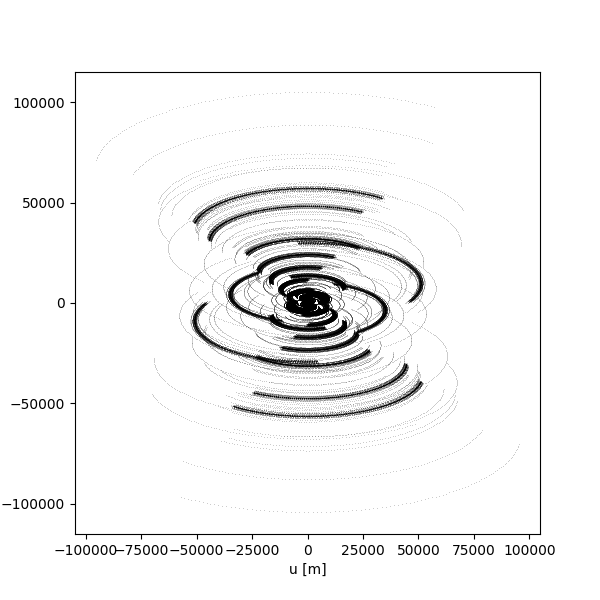

In [23]:
MS_parent = Path("/home/bbd0953/diffusion/sky_maps/test_map_80/synthms")
MS_file = MS_parent / "test_map_80_t201811301614_SBH225.MS"

fig, ax = get_uv_figax(MS_file)

# Add info to fits file

In [26]:
f_in = Path("/home/bbd0953/diffusion/sky_maps/test_map_80/test_map_80.fits")

from astropy.io import fits

hdul = fits.open(f_in, mode="update")

In [27]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2400                                                  
NAXIS2  =                 2400                                                  
EXTEND  =                    T                                                  
WCSAXES =                    2                                                  
CTYPE1  = 'RA---SIN'                                                            
CTYPE2  = 'DEC--SIN'                                                            
CUNIT1  = 'deg     '                                                            
CUNIT2  = 'deg     '                                                            
RADESYS = 'ICRS    '                                                            
EQUINOX =               2000

In [28]:
# Access the primary HDU header
header = hdul[0].header

# Add or update the header keywords
header["BUNIT"] = "Jy"  # Units of the data

header["WCSAXES"] = 2  # Number of coordinate axes
header["CTYPE1"] = "RA---SIN"  # Coordinate type
header["CTYPE2"] = "DEC--SIN"  # Coordinate type
header["CUNIT1"] = "deg"  # Units
header["CUNIT2"] = "deg"  # Units

header["RADESYS"] = "ICRS"  # Coordinate reference frame
header["EQUINOX"] = 2000.0  # Equinox of coordinates
header["LONPOLE"] = 180.0  # Native longitude of celestial pole
header["LATPOLE"] = 0.0  # Celestial latitude of native pole

header["CRVAL1"] = 0.031250  # Center RA coordinate
header["CRVAL2"] = 23.395251  # Center DEC coordinate
header["CDELT1"] = -1.5 / 3600  # Pixel size in degrees (or appropriate unit)
header["CDELT2"] = 1.5 / 3600  # Pixel size in degrees (or appropriate unit)
header["NAXIS1"] = 2400  # Total side length in pixels (X-axis)
header["NAXIS2"] = 2400  # Total side length in pixels (Y-axis)
header["CRPIX1"] = 1200  # Reference pixel X-coordinate
header["CRPIX2"] = 1200  # Reference pixel Y-coordinate

header["CTYPE3"] = "FREQ"
header["CUNIT3"] = "Hz"
header["CRVAL3"] = 143650000.0
header["CDELT3"] = 48000000.0

# Access image
image = hdul[0].data

# Update the image data: facter 1000 to convert from mJy to Jy
# image *= 1e-3

# Save the changes
hdul.flush()
hdul.close()

In [42]:
import numpy as np

np.deg2rad(0.031250), np.deg2rad(23.395251)

(0.000545415391248228, 0.40832415928049587)

In [ ]:
hdul[0].data.shape

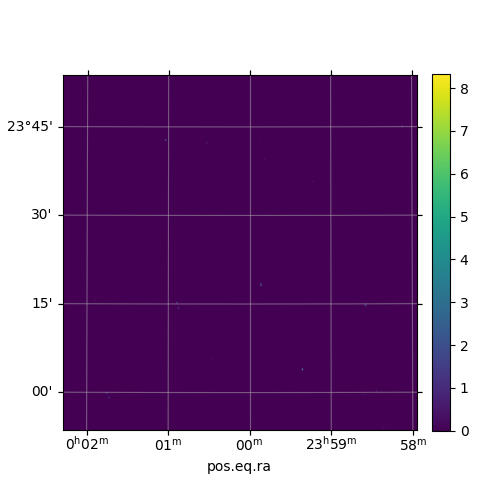

(<Figure size 500x500 with 2 Axes>, <WCSAxes: >)

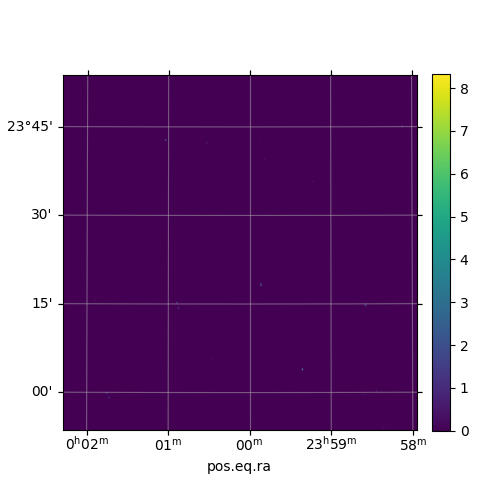

In [10]:
%matplotlib widget
from astropy.wcs import WCS
import np as np

# Plot map
def plot_map(image):
    fig, ax = plt.subplots(
        figsize=(5, 5),
        subplot_kw={'projection': WCS(hdul[0].header), 'slices': ('x', 'y', 0)})
    plt.colorbar(
        ax.imshow(image.squeeze(), origin="lower"), fraction=0.046, pad=0.04
    )
    ax.grid(alpha=0.5)
    fig.show()
    return fig, ax

plot_map(hdul[0].data)

# Simulate pointing position for mock observation

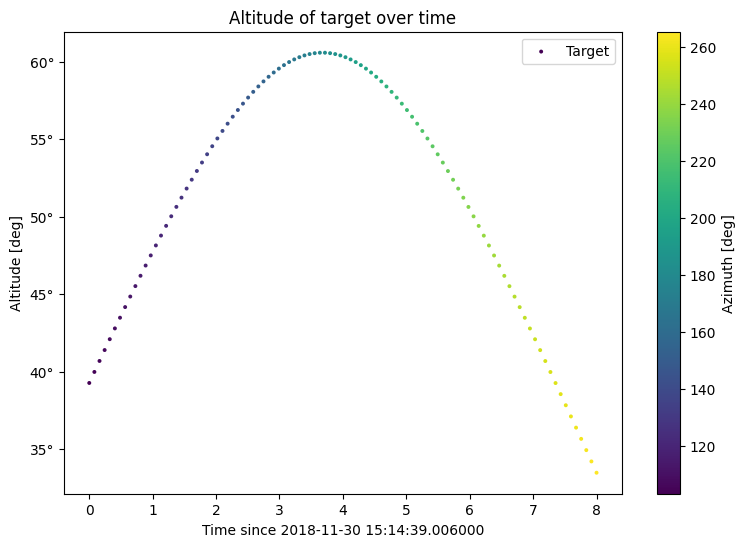

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.visualization import astropy_mpl_style, quantity_support
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

# Target: RA = 180 deg, DEC = 45 deg
# Starting time: 2018-06-30 11:00:02.003

# Set up matplotlib style for quantity support
# plt.style.use(astropy_mpl_style)
quantity_support()

target = SkyCoord(0.031250, 23.395251, unit="deg")
location = EarthLocation.of_site("LOFAR")

utcoffset = 0 * u.hour  # CEST = UTC+2
t_start = Time("2018-11-30 15:14:39.006") - utcoffset  # Local time to UTC
t_deltas = np.linspace(0, 8, 100) * u.hour
target_frame = AltAz(obstime=t_start + t_deltas, location=location)
altaz = target.transform_to(target_frame)

%matplotlib inline
fig, ax = plt.subplots(figsize=(9, 6))
scat = ax.scatter(
    t_deltas, altaz.alt, label="Target", c=altaz.az.value, cmap="viridis", lw=0, s=8
)
ax.set_xlabel(f"Time since {t_start.datetime}")
ax.set_ylabel("Altitude [deg]")
ax.set_title("Altitude of target over time")
ax.legend()
plt.colorbar(scat).set_label("Azimuth [deg]")
fig.show()

In [37]:
Time("2018-11-30 15:14:39.006").mjd * 3600 * 24

5050307679.0060005

# Compare Size Distributions

In [2]:
# Read 5deg simulation data
from astropy.table import Table

file = Path(
    "/home/bbd0953/diffusion/trecs_output/5deg/catalogue_continuum_wrapped.fits"
)

trecs_df = Table.read(file, hdu=1, unit_parse_strict="silent").to_pandas()

In [ ]:
# Apply SS-AGn cut
SS_AGN_flag = trecs_df["RadioClass"] == 6
SS_AGN_df = trecs_df[SS_AGN_flag]

# Apply size cutoff
size_cutoff = 35  # arcsec
cutoff_flag = SS_AGN_df["size"] >= size_cutoff
SS_AGN_df_cutoff = SS_AGN_df[cutoff_flag]

print(len(SS_AGN_df_cutoff))

In [4]:
# Read mask metadata from prototypes
import utils.paths as paths
import pandas as pd

mask_metadata = pd.read_hdf(paths.LOFAR_SUBSETS["prototypes"], key="mask_metadata")

# Apply size cutoff
cutoff_flag = mask_metadata["feret_diameter_max"] * 1.5 >= size_cutoff
mask_metadata_cut = mask_metadata[cutoff_flag]

# Select random rows from mask metadata to have same number of sources as SS AGN
mask_metadata_sample = mask_metadata_cut.sample(n=len(SS_AGN_df_cutoff))
mask_metadata_sample = mask_metadata_cut

In [5]:
# Load catalog instead
ptypes_cat = pd.read_hdf(paths.LOFAR_SUBSETS["prototypes"], key="catalog")

# Apply size cutoff
cutoff_flag = ptypes_cat["LAS"] * 1.5 >= size_cutoff
ptypes_cat_cut = ptypes_cat[cutoff_flag]

# Select random rows from mask metadata to have same number of sources as SS AGN
ptypes_cat_sample = ptypes_cat_cut.sample(n=len(SS_AGN_df_cutoff))
ptypes_cat_sample = ptypes_cat_cut

In [6]:
# Finally, read resolved LoTSS catalogue
resolved_df = pd.read_csv(paths.LOFAR_RES_CAT)

# Apply size cutoff
cutoff_flag = resolved_df["LAS"] >= size_cutoff
resolved_df_cut = resolved_df[cutoff_flag]

# Apply luminosity AGN cut
# Number of sources above and below 10^25 W/Hz in prototypes set
lum_threshold = 10**25
lum_cut_flag = resolved_df_cut["L_144"] > lum_threshold
resolved_df_cut = resolved_df_cut[lum_cut_flag]


# Select random rows from resolved LoTSS catalogue to have same number of sources as SS AGN
resolved_df_sample = resolved_df_cut.sample(n=len(SS_AGN_df_cutoff))
resolved_df_sample = resolved_df_cut

In [ ]:
# Compare distributions of size
import np as np

fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=150)

bins = np.linspace(size_cutoff, 1000, 25)

ax.hist(
    resolved_df_sample["LAS"],
    bins=bins,
    label="Resolved LoTSS (AGN Cut)",
    density=True,
    alpha=0.3,
)
ax.hist(
    SS_AGN_df_cutoff["size"], bins=bins, label="TRECS SS-AGN", alpha=0.3, density=True
)
ax.hist(
    mask_metadata_sample["feret_diameter_max"] * 1.5,
    bins=bins,
    label="Training Data Mask Size",
    histtype="step",
    density=True,
)
ax.hist(
    ptypes_cat["LAS"],
    bins=bins,
    label="Training Data LAS",
    histtype="step",
    density=True,
)

ax.set_xlabel("Size (arcsec)")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)

ax.set_yscale("log")
ax.set_title(f"Cut at {size_cutoff} arcsec")

fig.show()

# MapMaker implementation

In [ ]:
import utils.paths as paths

reload(paths)
import maps.map_maker as mapmaker

reload(mapmaker)

trecs_cat_file = paths.BASE_PARENT / "trecs_output/catalogue_continuum_wrapped.fits"

# Create a map
mm = mapmaker.MapMaker(
    map_size_deg=1,
    model_name="Prototypes_Model_SizeCond",
    trecs_cat_file=trecs_cat_file,
    dset="prototypes",
)

In [ ]:
mm.make_map()

In [ ]:
import data.cutouts

reload(data.cutouts)

mm.save("test_map_80")

In [ ]:
%matplotlib widget
mm.plot_map(scale_fn=lambda x: x)
%matplotlib inline

In [ ]:
import maps.map_maker as mapmaker

reload(mapmaker)
mm_read = mapmaker.MapMaker.from_hdf("test_map_80")

In [ ]:
%matplotlib widget
mm_read.plot_map(scale_fn=lambda x: x)
%matplotlib inline

In [ ]:
mm_read.plot_map()

In [ ]:
mm_read.map_array.shape

In [ ]:
%matplotlib inline
plt.hist(mm_read.ext_df['context_size'].values, bins=10)
plt.show()

In [ ]:
import plotting.image_plots

reload(plotting.image_plots)

from plotting.image_plots import metric_peek
import np as np

metric_peek(
    mm_read.ext_df["context_size"].values,
    np.linspace(60, 120, 7),
    mm_read.ext_data["images"],
    # masks=mm_read.ext_data['masks'],
    fmt_str="{:.2f}",
    metric_name="Source Size (px)",
)

In [22]:
from astropy.table import Table

trecs_file = "/home/bbd0953/diffusion/trecs_output/catalogue_continuum_wrapped.fits"
trecs_df = Table.read(trecs_file, hdu=1, unit_parse_strict="silent").to_pandas()

In [ ]:
# Plot input size distribution vs. TRECS SS-AGN size distribution

AGN_flag = trecs_df["RadioClass"] == 6
AGN_df = trecs_df[AGN_flag]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    AGN_df["size"],
    bins=150,
    alpha=0.8,
    label="TRECS SS-AGN",
    histtype="step",
    density=True,
)
size_px, bins = mm_read.model_size_distribution
ax.stairs(size_px * 1.5, bins, label="Training Data", alpha=0.8)

ax.set_xlabel("Size (arcsec)")
ax.set_ylabel("Count")
ax.set_yscale("log")
ax.set_xlim(left=-10, right=250)
ax.grid(alpha=0.3)
ax.legend()

fig.show()

In [ ]:
from plotting.image_plots import plot_image_grid
from data.transforms import minmax_scale
import np as np

n = 18
idxs = np.random.choice(len(mm_read.comp_images), n, replace=False)
imgs = [minmax_scale(mm_read.comp_images[i]) for i in idxs]

plot_image_grid(imgs, n_cols=6)

## Closer look at mask generation

In [ ]:
i = 363
img = mm_read.ext_data["images"][i]
mask = mm_read.ext_data["masks"][i]
plt.imshow(img)
plt.contour(mask, levels=[0.5], colors="r")

In [ ]:
plt.imshow(img * (1 - mask))

In [32]:
from data.segment import *
from scipy.ndimage import (
    binary_fill_holes,
    binary_closing,
    binary_opening,
    binary_dilation,
    binary_erosion,
)


def get_sample_mask(img, expand=False, dilate=0):
    cmask = circular_mask(img.shape)
    safe_background = img[~cmask].flatten()
    source_mask = img > np.mean(safe_background) + 3 * safe_background.std()

    # Iteratively expand to 1 sigma
    if expand:
        i = 0
        while i < 10:
            background = img[~source_mask].flatten()
            exp_mask = img > np.mean(background) + 1.5 * background.std()
            if np.all(exp_mask == source_mask):
                break
            source_mask = expand_islands(source_mask, exp_mask)
            i += 1

    source_mask = smooth_mask(source_mask)

    if dilate:
        source_mask = binary_dilation(source_mask, iterations=dilate)

    return source_mask.astype(int)

In [ ]:
cmask = circular_mask(img.shape)

plt.imshow(img * (1 - cmask))

In [ ]:
from data.datasets import LOFARPrototypesDataset

dset = LOFARPrototypesDataset("prototypes", img_size=80)

In [ ]:
plt.hist(dset.mask_sizes)

In [ ]:
metric_peek(
    dset.mask_sizes,
    np.linspace(80, 81, 1),
    dset.data,
    masks=dset.masks,
    n_examples=20,
    fmt_str="{:.2f}",
    metric_name="Mask Size",
)

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(1, 1)
ax.scatter(dset.mask_sizes/2, dset.mask_metadata['Model_Radius'])
ax.grid(alpha=0.3)
ax.set_xlabel("Mask Size / 2")
ax.set_ylabel("Model Radius")
fig.show()
%matplotlib inline


# Make Map

In [ ]:
# Load TRECS catalog for positions
from astropy.io import fits
from astropy.table import Table, vstack
import pandas as pd
import utils.paths as paths

trecs_cat_file = paths.BASE_PARENT / "trecs_output/catalogue_continuum_wrapped.fits"
tbl = Table.read(trecs_cat_file, hdu=1)
trecs_df = tbl.to_pandas()

# Classes:
# 1 - 3: SFGs
# 4: FSRQ, 5: BL-Lac, 6: SS-AGN
class_flag = trecs_df["RadioClass"].values
class_df_dict = {
    "SFG": trecs_df[class_flag < 4],
    "FSRQ_&_BL-Lac": trecs_df[(class_flag > 3) & (class_flag < 6)],
    "SS-AGN": trecs_df[class_flag == 6],
}

In [ ]:
(17.73 + 13.74) / 2

In [ ]:
class_df_dict["FSRQ_&_BL-Lac"]

In [ ]:
# Load prototypes dataset to model size distribution
import np as np
import data.datasets as dsts

reload(dsts)
from scipy.stats import rv_histogram

ptypes = dsts.LOFARPrototypesDataset("prototypes", load_catalog=True, img_size=200)

size_hist = np.histogram(ptypes.mask_metadata["feret_diameter_max"], bins=100)
rvh_size = rv_histogram(size_hist)

# Load train set (same set but with img size reduced) to get box-cox parameters
train_set = dsts.LOFARPrototypesDataset("prototypes", img_size=80)

Sanity check: compare distributions

In [ ]:
# Load LOFAR resolved catalog to model LAS distribution
import pandas as pd
from utils.paths import LOFAR_RES_CAT

# Load catalog
cat_df = pd.read_csv(LOFAR_RES_CAT)

# Luminosity cut to select AGN subsample
lum_thr = 1e25
agn_df = cat_df[cat_df["L_144"] > lum_thr]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
kwargs = {"histtype": "step", "density": True, "alpha": 0.7}
ax.hist(cat_df["LAS"], bins=np.linspace(0, 500, 101), label="Catalog LAS", **kwargs)
ax.hist(
    train_set.mask_metadata["feret_diameter_max"],
    bins=100,
    label="Train Set Mask Size",
    **kwargs
)
ax.hist(
    train_set.catalog["LAS"],
    bins=np.linspace(0, 500, 101),
    label="Train Set LAS",
    **kwargs
)

ax.set_xlabel("Size")
ax.set_ylabel("Norm. Count")
ax.grid(alpha=0.3)
ax.set_yscale("log")
ax.legend()

fig.show()

In [ ]:
from scipy.stats import rv_histogram

size_hist = np.histogram(train_set.mask_metadata["feret_diameter_max"], bins=100)
rvh_size = rv_histogram(size_hist)
samples = rvh_size.rvs(size=100000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.hist(
    train_set.mask_metadata["feret_diameter_max"], bins=100, label="Train Set", **kwargs
)
plt.hist(samples, bins=100, label="Sampled", **kwargs)

ax.set_xlabel("Size")
ax.set_ylabel("Count")
ax.grid(alpha=0.3)
ax.legend()
ax.set_yscale("log")

fig.show()

In [ ]:
# Load model
import model.model_utils as mutils
from utils.device_utils import distribute_model, collect_model

model_name = "Prototypes_Model_SizeCond"
model = mutils.load_model(model_name)
model, device = distribute_model(model)

In [5]:
# Sample source sizes
sizes = rvh_size.rvs(size=len(class_df_dict["SS-AGN"]))

# Convert to context model input:
context = sizes.reshape(-1, 1)
# Clamp to maximum size
context = np.clip(context, 0, 120)
# Box-cox transform
import model.model_utils as mutils

reload(mutils)
transforms = mutils.load_data_transforms(model_name)
# pt = train_set.data_transforms["mask_sizes"]
pt = transforms["mask_sizes"]
context_tr = torch.Tensor(pt.transform(context))

In [ ]:
# Sanity check: Plot distributions
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

kwargs = {"histtype": "step", "density": True, "alpha": 0.7}

ax = axs[0]
ax.hist(sizes, bins=100, label="Sampled", **kwargs)
ax.hist(context, bins=100, label="Clamped", **kwargs)

ax = axs[1]
ax.hist(context_tr.np(), bins=100, label="Transformed", **kwargs)

for ax in axs:
    ax.set_xlabel("Size")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)
    ax.legend()
    ax.set_yscale("log")

fig.show()

In [ ]:
# Load sampler and sample images
import model.sampler as smplr

sampler = smplr.Sampler()

samples = sampler.quick_sample(
    model=model,
    distribute_model=False,
    context=context_tr,
)
AGN_images = samples[:, -1].squeeze()
model = collect_model(model)

In [ ]:
# Sanity check: Metric peek sizes
from plotting.image_plots import metric_peek

metric_peek(
    context.squeeze(),
    np.linspace(0, 120, 11),
    source_images,
    fmt_str="{:.1f}",
)

In [8]:
# Rescale images
from skimage.transform import rescale


def upscale_image(img, current_size, target_size):
    assert (
        current_size < target_size
    ), f"Upscaling only! {current_size} -> {target_size}"
    scale_factor = target_size / current_size
    return rescale(img, scale_factor, anti_aliasing=True)

In [ ]:
# Sanity check: Test the rescaling
rescale_flag = sizes != context.squeeze()
rescale_idxs = np.where(rescale_flag)[0]

for i in rescale_idxs:
    img = AGN_images[i]
    current_size = context.squeeze()[i]
    target_size = sizes[i]

    img_rescaled = upscale_image(img, current_size, target_size)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img)
    axs[0].set_title(f"Size: {current_size:.1f}, shape: {img.shape}")
    axs[1].imshow(img_rescaled)
    axs[1].set_title(f"Size: {target_size:.1f}, shape: {img_rescaled.shape}")

    for ax in axs:
        ax.axis("off")

    fig.show()

In [ ]:
# Calculate masks for the images
from data.segment import get_sample_mask

AGN_masks = np.array([get_sample_mask(i) for i in AGN_images])

# Get region properties for masks
from skimage.measure import regionprops_table
from tqdm import tqdm

AGN_regionprops = [
    regionprops_table(
        mask, properties=("centroid", "area", "bbox", "feret_diameter_max")
    )
    for mask in tqdm(AGN_masks, desc="Calculating region properties")
]
# Convert arrays with one entry to scalars
for d in AGN_regionprops:
    for k, v in d.items():
        d[k] = v[0]
# Convert to DataFrame
# AGN_regionprops = pd.DataFrame(AGN_regionprops)

# New: Apply masked minmax first to prevent sharp edges for bright sources
import data.transforms

reload(data.transforms)
from data.transforms import minmax_scale_masked

AGN_images = np.array(
    [minmax_scale_masked(im, ms) for im, ms in tqdm(zip(AGN_images, AGN_masks))]
)

# Rescale images with fluxes from catalog
fluxes = class_df_dict["SS-AGN"]["I144"].values
pixel_sums = AGN_images.sum(axis=(1, 2))
AGN_images = AGN_images * (fluxes / pixel_sums)[:, None, None]

In [ ]:
AGN_regionprops

In [9]:
# Initialize empty map array with given resolution.
map_size_deg = 1.0
map_size_px = map_size_deg * 3600 / 1.5  # 1.5 arcsec/px
map_size_px = int(map_size_px)

map_array = np.zeros((map_size_px, map_size_px))

In [10]:
# Function for adding images to the map
def add_source_image(source_arr, map_array, coords, centroid=None):
    # Convert coords to pixel coords
    x, y = coords
    x_px, y_px = int((x + 0.5 * map_size_deg) * map_size_px), int(
        (y + 0.5 * map_size_deg) * map_size_px
    )

    # Set centroid coords
    x_c, y_c = (
        centroid if centroid is not None else (img.shape[0] // 2, img.shape[1] // 2)
    )

    # Determine slices for adding source to map
    x_slice = slice(x_px - x_c, x_px - x_c + source_arr.shape[0])
    y_slice = slice(y_px - y_c, y_px - y_c + source_arr.shape[1])

    # Check if source is within map, otherwise correct slice to fit
    # and reduce source_arr accordingly
    if x_slice.start < 0:
        source_arr = source_arr[-x_slice.start :, :]
        x_slice = slice(0, x_slice.stop)
    if x_slice.stop > map_size_px:
        source_arr = source_arr[: map_size_px - x_slice.stop, :]
        x_slice = slice(x_slice.start, map_size_px)
    if y_slice.start < 0:
        source_arr = source_arr[:, -y_slice.start :]
        y_slice = slice(0, y_slice.stop)
    if y_slice.stop > map_size_px:
        source_arr = source_arr[:, : map_size_px - y_slice.stop]
        y_slice = slice(y_slice.start, map_size_px)

    # Add source to map
    map_array[x_slice, y_slice] += source_arr
    return map_array

In [11]:
# Function for generating normalized 2d Gaussian signal, possibly convolved by beam
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter, rotate


def gaussian_signal(size=1, angle=0, convolve=True, img_size=80):
    if angle != 0:
        out_size = img_size
        img_size = int(np.sqrt(2) * img_size)

    # Data
    x = np.linspace(-img_size // 2, img_size // 2, img_size)
    y = x.copy()
    X, Y = np.meshgrid(x, y)

    if size == 0.0:
        print("Zero size converted to single pixel")
        size = 1.5  # arcsec = 1 px

    # Set sigma in x and y direction
    match size:
        case int() | float():
            sigma_x = size
            sigma_y = size
        case tuple() | list():
            sigma_x, sigma_y = size

    # 1.5 arcsec/px, size in arcsec and sigma in px
    sigma_x /= 1.5
    sigma_y /= 1.5

    # Gaussian
    rv = multivariate_normal([0, 0], [[sigma_x, 0], [0, sigma_y]])

    # Probability Density
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    pd = rv.pdf(pos)

    # Rotate and crop to output size
    if angle != 0:
        pd = rotate(pd, angle, reshape=False)
        start, end = img_size // 2 - out_size // 2, img_size // 2 + out_size // 2
        pd = pd[start:end, start:end]

    # Normalize to 1
    pd /= pd.sum()

    # Convolve with beam
    if convolve:
        # Beam size: FWHM = 6 arcsec = 4 px
        pd = gaussian_filter(pd, sigma=4 / 2.355)

    return pd

In [ ]:
# Place AGNs on map such that centroid matches the catalog x, y position
for i, (_, source) in tqdm(enumerate(class_df_dict["SS-AGN"].iterrows())):

    # Get pixel coordinates
    x, y = source.x_coord, source.y_coord
    x_px, y_px = int((x + 0.5 * map_size_deg) * map_size_px), int(
        (y + 0.5 * map_size_deg) * map_size_px
    )

    # If necessary, upscale image
    if (target_size := sizes[i]) != (current_size := context.squeeze()[i]):
        img = upscale_image(AGN_images[i], current_size, target_size)
        mask = get_sample_mask(img)
        source_arr = img * mask

    else:
        source_arr = AGN_images[i] * AGN_masks[i]

    # Identify slice such that source is added
    centroid = (
        AGN_regionprops.iloc[i]["centroid-0"],
        AGN_regionprops.iloc[i]["centroid-1"],
    )
    x_c, y_c = int(centroid[1]), int(centroid[0])

    map_array = add_source_image(source_arr, map_array, (x, y), centroid=(x_c, y_c))

In [ ]:
# Add unresolved AGNs
for i, (_, source) in tqdm(enumerate(class_df_dict["FSRQ_&_BL-Lac"].iterrows())):
    # Get pixel coordinates
    x, y = source.x_coord, source.y_coord
    x_px, y_px = int((x + 0.5 * map_size_deg) * map_size_px), int(
        (y + 0.5 * map_size_deg) * map_size_px
    )

    # Get flux
    flux = source.I144

    # Generate Gaussian signal
    source_arr = gaussian_signal(size=source.size, img_size=80) * flux

    # Add to map
    map_array = add_source_image(source_arr, map_array, (x, y))

In [ ]:
# Add SFGs
for i, (_, source) in tqdm(
    enumerate(class_df_dict["SFG"].iterrows()), total=len(class_df_dict["SFG"])
):
    # Get pixel coordinates
    x, y = source.x_coord, source.y_coord

    # Get flux
    flux = source.I144
    size = (source.bmaj, source.bmin)
    ang = source.PA

    # Generate Gaussian signal
    source_arr = gaussian_signal(size, angle=ang, img_size=80) * flux

    # Add to map
    map_array = add_source_image(source_arr, map_array, (x, y))

In [ ]:
%matplotlib widget

a = 7
scale_fn = lambda x: np.tanh(a * x)

fig, ax = plt.subplots(1, 1, figsize=(9, 9), tight_layout=True)

plt.colorbar(ax.imshow(scale_fn(map_array), origin='lower'), fraction=0.046, pad=0.04)
ax.axis('off')
fig.show()

%matplotlib inline

In [18]:
# Save to .fits
from astropy.io import fits

hdu = fits.PrimaryHDU(map_array)

out_file = Path("/home/bbd0953/diffusion/sky_maps/example_map.fits")

hdu.writeto(out_file, overwrite=True)

In [ ]:
%matplotlib inline
# Pixel stats for scaled view

a = 0.5
scale_fn = lambda x: np.tanh(a * x)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

ax = axs[0]
ax.hist(map_array.flatten(), bins=100, histtype='step', density=True, label='Map Flux')
ax.set_xlabel('Flux')

ax = axs[1]
ax.hist(scale_fn(map_array.flatten()), bins=100, histtype='step', density=True, label='Scaled Map Flux')
ax.set_xlabel('Scaled Flux')

for ax in axs:
    ax.set_ylabel('Norm. Count')
    ax.grid(alpha=0.3)
    ax.set_yscale('log')
    ax.legend()

fig.show()

# 2D Interpolation

In [ ]:
from plotting.image_plots import plot_image_grid
import data.transforms

reload(data.transforms)
from data.transforms import minmax_scale_batch

idxs = np.random.choice(len(AGN_images), 25, replace=False)
AGN_images_sc = minmax_scale_batch(AGN_images)

plot_image_grid(
    AGN_images_sc[idxs],
    AGN_masks[idxs],
    titles=idxs,
)

In [59]:
import np as np
import matplotlib.pyplot as plt
from scipy.interpolate import CloughTocher2DInterpolator as CT


def my_CT(xy, z):
    """CT interpolator + nearest-neighbor extrapolation.
    https://docs.scipy.org/doc/scipy/tutorial/interpolate/extrapolation_examples.html#extrapolation-in-d-1

    Parameters
    ----------
    xy : ndarray, shape (npoints, ndim)
        Coordinates of data points
    z : ndarray, shape (npoints)
        Values at data points

    Returns
    -------
    func : callable
        A callable object which mirrors the CT behavior,
        with an additional neareast-neighbor extrapolation
        outside of the data range.
    """
    x = xy[:, 0]
    y = xy[:, 1]
    f = CT(xy, z)

    # this inner function will be returned to a user
    def new_f(xx, yy):
        # evaluate the CT interpolator. Out-of-bounds values are nan.
        zz = f(xx, yy)
        nans = np.isnan(zz)

        if nans.any():
            # for each nan point, find its nearest neighbor
            inds = np.argmin(
                (x[:, None] - xx[nans]) ** 2 + (y[:, None] - yy[nans]) ** 2, axis=0
            )
            # ... and use its value
            zz[nans] = z[inds]
        return zz

    return new_f

In [101]:
from scipy.interpolate import (
    CloughTocher2DInterpolator,
    LinearNDInterpolator,
    NearestNDInterpolator,
)
from scipy.ndimage import binary_dilation


def add_outer_edges(mask, e=1):
    mask[e - 1, :] = 1
    mask[-e, :] = 1
    mask[:, e - 1] = 1
    mask[:, -e] = 1
    return mask


def iterative_extrapolation(img, mask, e=1):
    mask_dilated = mask.copy()
    mask_with_edge = add_outer_edges(mask_dilated, e=e)
    img_extrap = (img * mask).copy()
    it_count = 0

    while (~mask_with_edge).any():
        mask_coords = np.argwhere(mask_with_edge)
        interp = NearestNDInterpolator(
            mask_coords, (img_extrap * mask_dilated)[mask_with_edge.astype(bool)]
        )
        mask_dilated = binary_dilation(mask_dilated)
        extrap_range = np.argwhere(mask_dilated & ~mask_with_edge).T
        extrap = interp(*extrap_range)
        img_extrap[extrap_range.T[:, 0], extrap_range.T[:, 1]] = extrap
        mask_with_edge = add_outer_edges(mask_dilated, e=e)
        it_count += 1

    print(f"Extrapolation took {it_count} iterations.")
    return img_extrap

In [ ]:
from scipy.interpolate import CloughTocher2DInterpolator

i = 713
img = AGN_images_sc[i]
mask = AGN_masks[i]

img_extrap = iterative_extrapolation(img, mask, e=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

vmax = 0.1

ax = axs[0]
ax.imshow(img * mask, vmax=vmax)

ax = axs[1]
ax.imshow(img_extrap, vmax=vmax)

for ax in axs:
    ax.axis("off")

fig.show()

In [ ]:
# 2D array with mask coordinates
mask_coords = np.argwhere(mask_with_edge)
interp = CloughTocher2DInterpolator(
    mask_coords, (img * mask)[mask_with_edge.astype(bool)]
)

# 2D grid with dilated mask image coordinates
X = np.arange(0, img.shape[0])
Y = np.arange(0, img.shape[1])
X, Y = np.meshgrid(X, Y)
Z = interp(X, Y).T

# Model unresolved sources

In [119]:
# Function for generating 2d Gaussian signal, possibly convolved by beam
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter, rotate


def gaussian_signal(size=1, angle=0, convolve=True, img_size=80):
    if angle != 0:
        out_size = img_size
        img_size = int(np.sqrt(2) * img_size)

    # Data
    x = np.linspace(-img_size // 2, img_size // 2, img_size)
    y = x.copy()
    X, Y = np.meshgrid(x, y)

    if size == 0.0:
        print("Zero size converted to single pixel")
        size = 1.5  # arcsec = 1 px

    # Set sigma in x and y direction
    match size:
        case int() | float():
            sigma_x = size
            sigma_y = size
        case tuple() | list():
            sigma_x, sigma_y = size

    # 1.5 arcsec/px, size in arcsec and sigma in px
    sigma_x /= 1.5
    sigma_y /= 1.5

    # Gaussian
    rv = multivariate_normal([0, 0], [[sigma_x, 0], [0, sigma_y]])

    # Probability Density
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    pd = rv.pdf(pos)

    # Rotate and crop to output size
    if angle != 0:
        pd = rotate(pd, angle, reshape=False)
        start, end = img_size // 2 - out_size // 2, img_size // 2 + out_size // 2
        pd = pd[start:end, start:end]

    # Normalize to 1
    pd /= pd.sum()

    # Convolve with beam
    if convolve:
        # Beam size: FWHM = 6 arcsec = 4 px
        pd = gaussian_filter(pd, sigma=4 / 2.355)

    return pd

In [ ]:
# Random pick
i = np.random.choice(len(class_df_dict["SFG"]))
bmin, bmaj, ang = class_df_dict["SFG"].iloc[i][["bmin", "bmaj", "PA"]]

signal_unc = gaussian_signal((bmaj, bmin), angle=ang, convolve=False)
signal = gaussian_signal((bmaj, bmin), angle=ang, convolve=True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

ax = axs[0]
ax.imshow(signal_unc, origin="lower")
ax.set_title("Unc. Signal")

ax = axs[1]
ax.imshow(signal, origin="lower")
ax.set_title("Signal")

for ax in axs:
    ax.axis("off")

fig.suptitle(f"Size: ({bmaj:.5f}, {bmin:.5f}), Angle: {ang:.2f}")
fig.show()

In [ ]:
# Model source as

# LoTSS Catalog statistics

In [ ]:
# LAS distribution in LOTSS-DR2 resolved catalog
import pandas as pd
from utils.paths import LOFAR_RES_CAT

# Load catalog
cat_df = pd.read_csv(LOFAR_RES_CAT)

In [ ]:
import data.datasets as dsts
import utils.paths as paths

# Load cutouts
cutouts_path = paths.CUTOUTS_DIR / "cutouts_200p_optC.hdf5"
cutouts = dsts.CutoutsDataset(cutouts_path)

In [ ]:
reload(dsts)
# Load prototypes ptypes_cut
ptypes = dsts.LOFARPrototypesDataset("prototypes", img_size=80, load_catalog=True)

In [ ]:
samples = dsts.SamplesDataset("Prototypes_Model")

In [ ]:
from data.segment import get_sample_mask

samples.masks = [get_sample_mask(img.squeeze().np()) for img in samples.data]

In [ ]:
from tqdm import tqdm
from skimage.measure import regionprops

samples_region_props = [
    regionprops(mask.astype(int))[0] for mask in tqdm(samples.masks)
]
samples.mask_sizes = np.array([rp.feret_diameter_max for rp in samples_region_props])

## Plotting

In [ ]:
# LAS distributions
import np as np

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = 100  # np.linspace(0, 20, 101)
ax.hist(
    cutouts.catalog["LAS"], bins=bins, label="Cutouts", density=True, histtype="step"
)
ax.hist(
    ptypes.catalog["LAS"], bins=bins, label="Prototypes", density=True, histtype="step"
)

ax.set_title("LAS distribution in LOTSS-DR2 resolved catalog")
ax.set_xlabel("LAS [arcsec]")
ax.set_ylabel("Count")

ax.legend()
ax.grid(alpha=0.3)

ax.set_yscale("log")

fig.show()

In [ ]:
# Flux distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = 100  # np.linspace(0, 20, 101)
ax.hist(
    cutouts.catalog["Total_flux"],
    bins=bins,
    label="Cutouts",
    density=True,
    histtype="step",
)
ax.hist(
    ptypes.catalog["Total_flux"],
    bins=bins,
    label="Prototypes",
    density=True,
    histtype="step",
)

ax.set_title("Total flux distribution in LOTSS-DR2 resolved catalog")
ax.set_xlabel("Total flux [Jy]")
ax.set_ylabel("Count")

ax.legend()
ax.grid(alpha=0.3)

ax.set_yscale("log")

fig.show()

In [ ]:
def adaptive_binning(x, min_points_per_bin, min_bin_width):
    # Sort the data by x
    x_sorted = np.sort(x)

    bin_edges = []
    bin_start = 0

    while bin_start < len(x_sorted):
        bin_end = bin_start + min_points_per_bin
        while bin_end < len(x_sorted) and (
            x_sorted[bin_end] - x_sorted[bin_start] < min_bin_width
        ):
            bin_end += 1

        if bin_end >= len(x_sorted):
            bin_end = len(x_sorted)

        bin_edges.append(x_sorted[bin_start])
        bin_start = bin_end

    bin_edges.append(x_sorted[-1])  # Ensure the last edge is included

    return bin_edges


def adaptive_binning_log(x, min_points_per_bin, min_bin_width):
    # Transform data to log-space
    log_x = np.log10(x)

    # Sort the data by log_x
    log_x_sorted = np.sort(log_x)

    bin_edges_log = []
    bin_start = 0

    while bin_start < len(log_x_sorted):
        bin_end = bin_start + min_points_per_bin

        # If value is zero, log is -inf, so we need to skip it
        if log_x_sorted[bin_start] == -np.inf:
            bin_start += 1
            continue

        while bin_end < len(log_x_sorted) and (
            log_x_sorted[bin_end] - log_x_sorted[bin_start] < min_bin_width
        ):
            bin_end += 1

        if bin_end >= len(log_x_sorted):
            bin_end = len(log_x_sorted)

        bin_edges_log.append(log_x_sorted[bin_start])
        bin_start = bin_end

    bin_edges_log.append(log_x_sorted[-1])  # Ensure the last edge is included

    # Transform bin edges back to the original space
    bin_edges = 10 ** np.array(bin_edges_log)

    return bin_edges

In [ ]:
# LAS vs Flux
from scipy.stats import binned_statistic

fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Scatter plot of LAS vs. total flux
ax = axs[0]

kwargs = {"s": 5, "alpha": 0.5}

ax.scatter(
    cutouts.catalog["LAS"], cutouts.catalog["Total_flux"], label="Cutouts", **kwargs
)
ax.scatter(
    ptypes.catalog["LAS"], ptypes.catalog["Total_flux"], label="Prototypes", **kwargs
)

ax.set_title("LAS vs. Total flux in LOTSS-DR2 resolved catalog")
ax.set_xlabel("LAS [arcsec]")
ax.set_ylabel("Total flux [Jy]")
ax.legend()
ax.grid(alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")

# Plot of median LAS vs. total flux
ax = axs[1]

# Cutouts
bin_edges = adaptive_binning_log(cutouts.catalog["LAS"], 50, 0.2)
bin_medians = binned_statistic(
    cutouts.catalog["LAS"],
    cutouts.catalog["Total_flux"],
    statistic="median",
    bins=bin_edges,
)[0]
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
ax.errorbar(
    bin_centers,
    bin_medians,
    xerr=0.5 * (bin_edges[1:] - bin_edges[:-1]),
    fmt="o",
    label="Cutouts",
)

# Prototypes
bin_edges = adaptive_binning_log(ptypes.catalog["LAS"], 50, 0.2)
bin_medians = binned_statistic(
    ptypes.catalog["LAS"],
    ptypes.catalog["Total_flux"],
    statistic="median",
    bins=bin_edges,
)[0]
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
ax.errorbar(
    bin_centers,
    bin_medians,
    xerr=0.5 * (bin_edges[1:] - bin_edges[:-1]),
    fmt="o",
    label="Prototypes",
)

ax.set_title("Median LAS vs. Total flux in LOTSS-DR2 resolved catalog")
ax.set_xlabel("LAS [arcsec]")
ax.set_ylabel("Total flux [Jy]")
ax.legend()

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.3)

fig.show()

In [ ]:
# LAS vs Luminosity
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Scatter plot of LAS vs. total flux
ax = axs[0]

kwargs = {"s": 5, "alpha": 0.5}

ax.scatter(cutouts.catalog["LAS"], cutouts.catalog["L_144"], label="Cutouts", **kwargs)
ax.scatter(ptypes.catalog["LAS"], ptypes.catalog["L_144"], label="Prototypes", **kwargs)

ax.set_title("LAS vs. Total flux in LOTSS-DR2 resolved catalog")
ax.set_xlabel("LAS [arcsec]")
ax.set_ylabel("Total flux [Jy]")
ax.legend()
ax.grid(alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")

# Plot of median LAS vs. total flux
ax = axs[1]

# Cutouts
bin_edges = adaptive_binning_log(cutouts.catalog["LAS"], 50, 0.2)
bin_medians = binned_statistic(
    cutouts.catalog["LAS"], cutouts.catalog["L_144"], statistic="median", bins=bin_edges
)[0]
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
ax.errorbar(
    bin_centers,
    bin_medians,
    xerr=0.5 * (bin_edges[1:] - bin_edges[:-1]),
    fmt="o",
    label="Cutouts",
)

# Prototypes
bin_edges = adaptive_binning_log(ptypes.catalog["LAS"], 50, 0.2)
bin_medians = binned_statistic(
    ptypes.catalog["LAS"], ptypes.catalog["L_144"], statistic="median", bins=bin_edges
)[0]
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
ax.errorbar(
    bin_centers,
    bin_medians,
    xerr=0.5 * (bin_edges[1:] - bin_edges[:-1]),
    fmt="o",
    label="Prototypes",
)

ax.set_title("Median LAS vs. Total flux in LOTSS-DR2 resolved catalog")
ax.set_xlabel("LAS [arcsec]")
ax.set_ylabel("Total flux [Jy]")
ax.legend()

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.3)

fig.show()

In [ ]:
# Luminosity distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = np.logspace(12, 30, 101)
ax.hist(
    cutouts.catalog["L_144"], bins=bins, label="Cutouts", density=False, histtype="step"
)
ax.hist(
    ptypes.catalog["L_144"],
    bins=bins,
    label="Prototypes",
    density=False,
    histtype="step",
)

ax.set_title("Luminosity distribution in LOTSS-DR2 resolved catalog")
ax.set_xlabel("Luminosity [W/Hz]")

# Vertical line at 10**25
ax.axvline(10**25, color="black", linestyle="--", label="10^25")

ax.legend()
ax.grid(alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")

fig.show()

## AGN Luminosity Cut

In [ ]:
# Number of sources above and below 10^25 W/Hz in prototypes set
lum_threshold = 10**25
ptypes_cut_flag = ptypes.catalog["L_144"] > lum_threshold

print(
    f"Number of sources above {lum_threshold:.0e} W/Hz: {ptypes_cut_flag.sum()} ({ptypes_cut_flag.sum() / len(ptypes.catalog) * 100:.2f}%)"
)
print(
    f"Number of sources below {lum_threshold:.0e} W/Hz: {(~ptypes_cut_flag).sum()} ({(~ptypes_cut_flag).sum() / len(ptypes.catalog) * 100:.2f}%)"
)

# Number of sources above and below 10^25 W/Hz in cutouts set
cutouts_cut_flag = cutouts.catalog["L_144"] > lum_threshold

print(
    f"Number of sources above {lum_threshold:.0e} W/Hz: {cutouts_cut_flag.sum()} ({cutouts_cut_flag.sum() / len(cutouts.catalog) * 100:.2f}%)"
)
print(
    f"Number of sources below {lum_threshold:.0e} W/Hz: {(~cutouts_cut_flag).sum()} ({(~cutouts_cut_flag).sum() / len(cutouts.catalog) * 100:.2f}%)"
)

In [ ]:
ptypes_cut = ptypes.index_sliced(ptypes_cut_flag.values)
cutouts_cut = cutouts.index_sliced(cutouts_cut_flag.values)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(
    cutouts_cut.catalog["LAS"],
    bins=100,
    density=False,
    histtype="step",
    label="Cutouts",
)
ax.hist(
    ptypes_cut.catalog["LAS"],
    bins=100,
    density=False,
    histtype="step",
    label="Prototypes",
)

# ax.set_xscale('log')
ax.set_yscale("log")

ax.set_title("LAS distribution in LOTSS-DR2 resolved catalog (L > 10^25 W/Hz)")
ax.set_xlabel("LAS [arcsec]")
ax.set_ylabel("Count")
ax.grid(alpha=0.3)
ax.legend()
fig.show()

In [ ]:
cutout_name_dict = {name: i for i, name in enumerate(cutouts_cut.names)}
slice_idxs = [cutout_name_dict[name] for name in ptypes_cut.names]
ptype_cutouts = cutouts_cut.index_sliced(np.array(slice_idxs))

In [ ]:
from data.transforms import minmax_scale_batch

img_pairs = np.concatenate(
    (
        ptypes_cut.data.squeeze().np(),
        minmax_scale_batch(ptype_cutouts.data.squeeze()).np(),
    ),
    axis=2,
)

In [ ]:
import plotting.image_plots

reload(plotting.image_plots)
from plotting.image_plots import metric_peek

metric_peek(
    ptypes_cut.catalog["LAS"].values,
    np.linspace(0, 500, 10),
    img_pairs,
    n_examples=15,
    metric_name="LAS (arsec)",
    fmt_str="{:.2f}",
)

In [ ]:
import plotting.image_plots

reload(plotting.image_plots)
from plotting.image_plots import metric_peek

metric_peek(
    cutouts_cut.catalog["LAS"].values,
    np.linspace(0, 750, 10),
    cutouts_cut.data.squeeze().np(),
    metric_name="LAS (arsec)",
    fmt_str="{:.2f}",
)

## Add mask size to dataset

In [ ]:
from tqdm import tqdm
from skimage.measure import regionprops, regionprops_table

properties = (
    "num_pixels",
    "orientation",
    "feret_diameter_max",
)

region_props = [
    regionprops_table(
        m.np().astype(int),
        properties=properties,
    )
    for m in tqdm(ptypes.masks)
]

In [ ]:
# Extract single entries from arrays
for d in region_props:
    for key in d:
        d[key] = d[key][0]

new_meta = pd.concat(
    [
        ptypes.mask_metadata,
        pd.DataFrame(region_props),
    ],
    axis=1,
)
new_meta

In [ ]:
# Replace mask_metadata df in file with new_meta
import h5py

with h5py.File(ptypes.path, "r+") as f:
    del f["mask_metadata"]

new_meta.to_hdf(ptypes.path, key="mask_metadata", mode="a")

In [ ]:
# Scatter plot size (in arcsec) vs LAS
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(
    ptypes.catalog["LAS"],
    ptypes.mask_metadata['feret_diameter_max'].values * 1.5,
    s=5,
    alpha=0.5,
    label="Prototypes",
)

# Plot identity and 1/2 identity
x = np.linspace(0, 500, 100)
ax.plot(x, x, "--", color="black", label="Identity", alpha=0.5)
# ax.plot(x, x / 2, "--", color="black", label="1/2 Identity", alpha=0.5)

ax.set_title("Size vs LAS for prototype dataset")

ax.set_xlabel("LAS [arcsec]")
ax.set_ylabel("Mask Size [arcsec]")

ax.set_xlim(left=0, right=300)
ax.set_ylim(bottom=0, top=300)

ax.legend()
ax.grid(alpha=0.3)

fig.show()

In [ ]:
las = ptypes.catalog["LAS"]
size = ptypes.mask_metadata["feret_diameter_max"].values * 1.5

nonzero_flag = las > 0
las = las[nonzero_flag]
size = size[nonzero_flag]

ratio = size / las

fig, axs = plt.subplots(3, 1, figsize=(10, 18))


ax = axs[0]
ax.scatter(
    las,
    size,
    s=5,
    alpha=0.5,
    label="Prototypes",
)

# Plot identity and 1/2 identity
x = np.linspace(0, 500, 100)
ax.plot(x, x, "--", color="black", label="Identity", alpha=0.5)
# ax.plot(x, x / 2, "--", color="black", label="1/2 Identity", alpha=0.5)

ax.set_title("Mask Size vs LAS for prototype dataset")

ax.set_xlabel("LAS [arcsec]")
ax.set_ylabel("Mask Size [arcsec]")

ax.set_xlim(left=0, right=300)
ax.set_ylim(bottom=0, top=300)

ax.legend()
ax.grid(alpha=0.3)

# Plot both distributions
ax = axs[1]
ax.hist(size, bins=250, density=True, histtype="step", label="Mask Size")
ax.hist(las, bins=750, density=True, histtype="step", label="LAS")

ax.set_title("Mask Size and LAS distributions for prototype dataset")
ax.set_xlabel("Size (arcsec)")
ax.set_ylabel("Count Density")
ax.grid(alpha=0.3)
ax.legend()

# ax.set_yscale('log')
ax.set_xlim(left=-0.1, right=500)


# Plot ratio distribution
ax = axs[2]
cts, bns, _ = ax.hist(ratio, bins=750, density=False, histtype="step")

# Vertical line at 0.5
ax.axvline(0.5, color="black", linestyle="--", label="0.5", alpha=0.5)

# Vertical line at count maximum
max_idx = np.argmax(cts)
max_val = (bns[max_idx] + bns[max_idx + 1]) / 2
ax.axvline(
    max_val, color="orange", linestyle="--", label=f"Max at {max_val:.2f}", alpha=0.5
)

ax.set_title("Mask Size/LAS ratio for prototype dataset")
ax.set_xlabel("Mask Size/LAS")
ax.set_ylabel("Count")
ax.grid(alpha=0.3)
ax.legend()

# ax.set_yscale('log')
ax.set_xlim(left=-0.01, right=3)
fig.show()

In [ ]:
# Box-cox transformation on size distribution
from scipy.stats import boxcox, rv_histogram
from scipy.special import inv_boxcox

size_bc, lambda_ = boxcox(size)

mean, std = size_bc.mean(), size_bc.std()

size_bc_standardized = (size_bc - mean) / std

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

ax = axs[0]
ax.hist(
    size_bc_standardized,
    bins=100,
    density=True,
    histtype="step",
    label="Mask Size (Box-Cox)",
)

# Plot gaussian to compare
x = np.linspace(-3, 3, 100)
gaussian = np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
ax.plot(x, gaussian, label="Gaussian", alpha=0.5)

ax.set_xlabel("Transformed Size")
ax.set_ylabel("Count Density")
ax.grid(alpha=0.3)
ax.legend()

ax = axs[1]
ax.hist(size, bins=250, density=True, histtype="step", label="Mask Size")
ax.hist(
    samples.mask_sizes * 1.5,
    bins=250,
    density=True,
    histtype="step",
    label="Sample Mask Size",
)

# Plot inverse-boxcox of randoms sampled from rv_histogram
rv_bins = 250
hist = np.histogram(size_bc_standardized, bins=250)
rv = rv_histogram(hist)
rv_randoms = rv.rvs(size=100000) * std + mean
inv_rv_randoms = inv_boxcox(rv_randoms, lambda_)
ax.hist(
    inv_rv_randoms,
    bins=rv_bins,
    density=True,
    histtype="step",
    label="Inverse Box-Cox of Mask Size",
    alpha=0.5,
)

# Plot inverse-boxcox of gaussian
if False:
    randoms = np.random.normal(0, 1, 10000) * std + mean
    inv_randoms = inv_boxcox(randoms, lambda_)
    ax.hist(
        inv_randoms,
        bins=100,
        density=True,
        histtype="step",
        label="Inverse Box-Cox of Gaussian",
        alpha=0.5,
    )

ax.set_xlabel("Size")
ax.set_ylabel("Count Density")
ax.grid(alpha=0.3)
ax.legend()

ax.set_yscale("log")

fig.show()

# T-RECS Catalogs

In [ ]:
from astropy.io import fits
from astropy.table import Table, vstack
import pandas as pd
import utils.paths as paths

trecs_cat_file = paths.BASE_PARENT / "trecs_output/catalogue_continuum_wrapped.fits"
tbl = Table.read(trecs_cat_file, hdu=1)
trecs_df = tbl.to_pandas()

# Classes:
# 1 - 3: SFGs
# 4: FSRQ, 5: BL-Lac, 6: SS-AGN
class_flag = trecs_df["RadioClass"].values
class_df_dict = {
    "SFG": trecs_df[class_flag < 4],
    "FSRQ_&_BL-Lac": trecs_df[(class_flag > 3) & (class_flag < 6)],
    "SS-AGN": trecs_df[class_flag == 6],
}

In [ ]:
# LAS distribution in LOTSS-DR2 resolved catalog
import pandas as pd
from utils.paths import LOFAR_RES_CAT

# Load catalog
cat_df = pd.read_csv(LOFAR_RES_CAT)

# AGN Cut
lum_threshold = 10**25
AGN_cut_flag = cat_df["L_144"] > lum_threshold

cat_df_AGN = cat_df[AGN_cut_flag]

## Plot some distributions

In [ ]:
import np as np

fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)

bins = np.linspace(0, 1000, 101)

kwargs = {
    "bins": bins,
    "log": True,
    "density": True,
    "histtype": "step",
}
# ax.hist(trecs_df["size"], label="T-RECS: All", **kwargs)
ax.hist(class_df_dict["SS-AGN"]["size"], label="T-RECS: SS-AGN", **kwargs)
# ax.hist(cat_df["LAS"], label='LoTSS-DR2 resolved: All', **kwargs)
ax.hist(cat_df_AGN["LAS"], label="LoTSS-DR2 resolved: AGN Cut", **kwargs)

ax.grid(alpha=0.3)
ax.set_xlabel("Size (arcsec)")
ax.set_ylabel("Norm. Counts")
ax.legend()

fig.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)

ax.scatter(AGN_df_res["size"], AGN_df_res["I144"], s=5)
ax.set_xscale("log")
ax.set_yscale("log")

ax.grid(alpha=0.3)
ax.set_xlabel("Size (arcsec)")
ax.set_ylabel("I144 (mJy)")

In [ ]:
# Scatter plot of the AGNs based on latitude and longitude coords
fig, ax = plt.subplots(1, 1, figsize=(10, 10), tight_layout=True)

colors = ["lightgray", "blue", "fuchsia"]
for (name, df), clr in zip(class_df_dict.items(), colors):
    ax.scatter(
        df["x_coord"], df["y_coord"], label=name.replace("_", " "), s=5, color=clr
    )

ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
ax.grid(alpha=0.2)
ax.legend(loc="upper center", ncols=3)

fig.show()

In [ ]:
# Size
px_size = 1.5  # arcsec
px_per_deg = 3600 / px_size
px_per_deg

## Rescaling of Source Images

In [ ]:
from data.datasets import SamplesDataset

ptypes_cut = SamplesDataset("Prototypes_Model")

In [ ]:
ptypes_cut.data.shape

In [ ]:
from tqdm import tqdm
import data.segment

reload(data.segment)
from data.segment import get_sample_mask
from skimage.measure import regionprops

# Analyse the dataset
ptypes_cut.masks = np.zeros_like(ptypes_cut.data.squeeze())
ptypes_cut.sizes_px = np.zeros(len(ptypes_cut))
ptypes_cut.region_props = []
for i in tqdm(range(len(ptypes_cut))):
    img = ptypes_cut[i].np().squeeze()
    mask = get_sample_mask(img)
    props = regionprops(mask.astype(int))[0]
    ptypes_cut.masks[i] = mask
    ptypes_cut.sizes_px[i] = props.feret_diameter_max
    ptypes_cut.region_props.append(props)

In [ ]:
ptypes_cut.plot_image_grid()

In [ ]:
i = 4792
img = ptypes_cut[i].np().squeeze()
mask = ptypes_cut.masks[i]
props = ptypes_cut.region_props[i]

plt.imshow(img[props.slice])

In [ ]:
# Compare distributions
from analysis.stats_utils import norm
from plotting.plot_utils import add_distribution_plot

fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)

bins = np.linspace(0, 150, 76)

c_smpl, _ = np.histogram(ptypes_cut.sizes_px, bins=bins)
c_AGN, _ = np.histogram(AGN_df_res["size"] / 1.5, bins=bins)
c_AGN_sc, _ = np.histogram(AGN_df_res["size"] * AGN_df_res["Rs"] / 1.5, bins=bins)

add_distribution_plot(c_smpl, bins, ax, label="Samples", color="blue")
add_distribution_plot(c_AGN, bins, ax, label="AGN", color="red")

ax.grid(alpha=0.3)
ax.set_xlabel("Size (px)")
ax.set_ylabel("Number of sources")
ax.legend()

fig.show()

In [ ]:
# LAS distribution in LOTSS-DR2 resolved catalog
import pandas as pd
from utils.paths import LOFAR_RES_CAT

cat_df = pd.read_csv(LOFAR_RES_CAT)

In [ ]:
zero_flag = cat_df.LAS == 0
cat_df_zero = cat_df[zero_flag]

cat_df_zero[["LAS", "LAS_from"]]

In [ ]:
cat_df.LAS.hist(bins=np.linspace(0, 1, 11), log=True)

In [ ]:
img = ptypes_cut[np.random.randint(0, len(ptypes_cut))].np().squeeze()
mask = get_sample_mask(img)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

axs[0].imshow(img)

axs[1].imshow(mask * img)
axs[1].contour(mask, levels=[0.5], colors="r")

In [ ]:
from skimage.measure import regionprops

props = regionprops(mask.astype(int))[0]
sample_size_px = props["feret_diameter_max"]
sample_size_px

In [ ]:
source = AGN_df_res.iloc[np.random.randint(0, len(AGN_df_res))]
target_size_px = source["size"] / 1.5  # 1.5 arcsec per pixel
target_size_px

In [ ]:
from skimage.transform import rescale
from scipy.ndimage import gaussian_filter

img_rescaled = rescale(mask * img, target_size_px / sample_size_px, anti_aliasing=False)
mask_rescaled = img_rescaled > 0

fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

ax = axs[0]
ax.imshow(img_rescaled)
ax.contour(mask_rescaled, levels=[0.5], colors="r")

ax = axs[1]
ax.imshow(gaussian_filter(img_rescaled, 4 / 2.355))

In [ ]:
props_rescaled = regionprops(mask_rescaled.astype(int))[0]
rescaled_size_px = props_rescaled["feret_diameter_max"]
rescaled_size_px

# Simulate Fields/Positions

In [ ]:
import np as np
import matplotlib.pyplot as plt


def log_corr_fn(A, gamma):
    return lambda r: np.log(1 + A * r**-gamma)


r = np.logspace(-1, 1, 100)
plt.plot(r, log_corr_fn(10**-2.5, 0.8)(r))
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
import np as np
from scipy.special import gamma as gamma_fn


def PL_correlation(A, gamma):
    return lambda r: A * r**-gamma


def PL_correlation_FT(A, gamma):
    alpha = -gamma
    return (
        lambda k: -2
        * np.sin(np.pi * alpha / 2)
        * gamma_fn(alpha + 1)
        * A
        / (2 * np.pi * np.abs(k)) ** (alpha + 1)
    )


xi = PL_correlation(10**-2.5, 0.8)
P = PL_correlation_FT(10**-2.5, 0.8)

x = np.linspace(0.01, 1000, 1000)
y_xi = xi(x)

k = np.fft.rfftfreq(len(x), x[1] - x[0])
fft = np.fft.fft(y_xi)

fig = plt.figure(figsize=(6, 10))
axs = []

ax = fig.add_subplot(311)
ax.plot(x, y_xi)
axs.append(ax)

ax = fig.add_subplot(312)
ax.plot(k, np.abs(fft)[: len(k)])
axs.append(ax)

ax = fig.add_subplot(313, projection="polar")
ax.plot(k, np.angle(fft)[: len(k)])
axs.append(ax)

for ax in axs[:-1]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(alpha=0.3)

plt.show()

In [ ]:
xi = PL_correlation(10**-2.5, 0.8)
P = PL_correlation_FT(10**-2.5, 0.8)

x = np.linspace(0.01, 15000, 100000)
y_xi = np.log(1 + xi(x))

k = np.fft.fftfreq(len(x), x[1] - x[0])
fft = np.fft.fft(y_xi)
ii = np.argsort(k)
k = k[ii]
fft = fft[ii]

fig = plt.figure(figsize=(6, 10))
axs = []

ax = fig.add_subplot(311)
ax.plot(x, y_xi)
axs.append(ax)

ax = fig.add_subplot(312)
ax.plot(k, np.real(fft))
axs.append(ax)

ax = fig.add_subplot(313)
ax.plot(k, np.imag(fft))
axs.append(ax)

for ax in axs[:-1]:
    # ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(alpha=0.3)

plt.show()

In [ ]:
from scipy.interpolate import interp1d, pchip_interpolate

# Random gaussian field in fourier space:
rand_real = np.random.normal(size=(1000, 500))
rand_imag = np.random.normal(size=(1000, 500))

# Vector lengths corresponding to positions on 2d grid
grid_idxs = np.linspace(-1 / 2, 1 / 2, 1000)
x, y = np.meshgrid(grid_idxs[grid_idxs > 0], grid_idxs)
k_grid = np.sqrt(x**2 + y**2)
plt.imshow(k_grid)
plt.show()

# Interpolate power spectrum to grid (only upper half)
upper_half = k > 0
P = interp1d(k[upper_half], fft[upper_half])
# P = lambda k_in: pchip_interpolate(k[upper_half], fft[upper_half], k_in)

G_F = np.sqrt(P(k_grid) * 1000**2 / 2) * (rand_real + 1j * rand_imag)

# Concatenate complex conjugate
# G_F = np.concatenate((np.flip(np.conj(G_F)), G_F), axis=1)
print(G_F.shape)
plt.imshow(np.abs(G_F))
plt.show()
plt.imshow(np.abs(np.fft.ifftshift(G_F, axes=0)))
plt.show()
G = np.fft.irfft2(np.fft.ifftshift(G_F, axes=0))

plt.colorbar(plt.imshow(np.real(G)))
plt.show()

plt.colorbar(plt.imshow(np.imag(G)))
plt.show()

In [ ]:
density = np.exp(G)
plt.colorbar(plt.imshow(density))

In [ ]:
from scipy.spatial.distance import cdist
import treecorr
import np as np
from tqdm import tqdm
from utils.device_utils import distribute_model


def two_point_correlation(points, wcs, n_pixel, f_random=20, **config_kwargs):
    # Sample random points
    random = np.random.rand(len(points) * f_random, 2) * n_pixel
    random = wcs.all_pix2world(random, 0)

    # Convert to treecorr catalog format
    cat_data = treecorr.Catalog(
        ra=points[:, 0], dec=points[:, 1], ra_units="deg", dec_units="deg"
    )
    cat_random = treecorr.Catalog(
        ra=random[:, 0], dec=random[:, 1], ra_units="deg", dec_units="deg"
    )

    # Set config for calculating correlation function
    config = {
        "nbins": 10,
        "min_sep": 0.01,
        "max_sep": 1,
    }
    config.update(config_kwargs)

    # Data-data correlation
    dd = treecorr.NNCorrelation(config)
    dd.process(cat_data)

    # Data-random correlation
    dr = treecorr.NNCorrelation(config)
    dr.process(cat_data, cat_random)

    # Random-random correlation
    rr = treecorr.NNCorrelation(config)
    rr.process(cat_random)

    # Calculate correlation function
    dd.calculateXi(rr=rr, dr=dr)

    return dd


def power_law(x, A, gamma):
    return A * x ** (-gamma)

## ParaFields

In [ ]:
import parafields


def powerlaw(variance, x):
    return variance * 10**-2.5 * np.linalg.norm(x) ** -0.8


parafields.generate_field(cells=(256, 256), covariance=powerlaw, variance=1)

In [ ]:
def exponential(variance, x):
    return variance * np.exp(-np.linalg.norm(x))


parafields.generate_field(cells=(256, 256), covariance=exponential, variance=0.1)

## GSTools

In [ ]:
from gstools import CovModel
import np as np


# use CovModel as the base-class
class PLModel(CovModel):
    def __init__(self, gamma=1, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma

    def cor(self, h):
        return h ** (-self.gamma)

In [ ]:
from gstools import SRF

model = PLModel(dim=2, var=0.22, len_scale=1, gamma=0.8)

srf = SRF(model)
x = y = np.linspace(0, 1, 128)
srf((x, y), mesh_type="structured")

srf.plot()

In [ ]:
from gstools.covmodel.plot import plot_variogram

plot_variogram(model)

## Lenstools

### 2PCF to PS through numerical integration

In [ ]:
import np as np
from scipy.special import legendre
from scipy.integrate import quad
from tqdm import tqdm


def w_to_cl(w, lmax, sigma_0):
    """
    Computes the angular power spectrum from the angular correlation function.

    Args:
      w: Angular correlation function as a function of theta.
      lmax: Maximum multipole moment.

    Returns:
      Angular power spectrum.
    """

    cl = np.zeros(lmax + 1)
    for l in tqdm(range(lmax + 1)):

        def integrand(theta):
            return w(theta) * legendre(l)(np.cos(theta)) * np.sin(theta)

        cl[l], _ = quad(integrand, 0, np.pi)
        cl[l] *= 2 * np.pi * sigma_0**2

    return cl

In [ ]:
w = lambda theta: 10**-2.5 * np.rad2deg(theta) ** -0.8
l_max = 100
cl = w_to_cl(w, l_max, 1)

In [ ]:
# Fit power law to angular power spectrum
from scipy.optimize import curve_fit

fit_max = 25

x = np.arange(l_max + 1)
popt, pcov = curve_fit(power_law, x[1:fit_max], cl[1:fit_max])

# Plot angular power spectrum
plt.scatter(x[1:], cl[1:], label="Angular power spectrum")

# Plot power law fit
plt.plot(x[1:], power_law(x[1:], *popt), label=f"A={popt[0]:.2e}, gamma={popt[1]:.2f}")

# plot PL from paper
plt.plot(x[1:], 2e-4 * x[1:] ** -1.2, label="Paper")

plt.legend()
plt.grid(alpha=0.3)
# plt.ylim(0, 4e-5)
plt.xscale("log")
plt.yscale("log")

### Simulate points

In [ ]:
import np as np
import matplotlib.pyplot as plt

from astropy.units import deg
import lenstools

reload(lenstools)

from lenstools import GaussianNoiseGenerator

# Set map side angle, and number of pixels on a side
num_pixel_side = 1024
side_angle = 1 * deg

# Set the power spectrum
cl = lambda l: 2e-4 * l**-1.2

# Instantiate the gaussian noise generator
gen = GaussianNoiseGenerator(
    shape=(num_pixel_side, num_pixel_side), side_angle=side_angle
)

# Generate one random realization
gaussian_map = gen.fromConvPower(cl)
overdensity = gaussian_map.data

# gaussian_map is a ConvergenceMap instance
plt.colorbar(plt.imshow(overdensity))

In [ ]:
exp_sources = 50_000
mean_density = exp_sources / num_pixel_side**2
density = mean_density * (1 + overdensity)

plt.colorbar(plt.imshow(density))

In [ ]:
# Sample from density field
coord_grid = np.array(
    np.meshgrid(*(np.linspace(0, side_angle.value, num_pixel_side),) * 2)
).T
point_idxs = np.argwhere(np.random.rand(*density.shape) < density)
points = coord_grid[point_idxs[:, 0], point_idxs[:, 1]]

In [ ]:
from plotting.map_plots import point_process_scatter_plot

point_process_scatter_plot(points, s=0.25, alpha=0.5)

In [ ]:
# Put points on WCS grid
from astropy.wcs import WCS

wcs = WCS(naxis=2)
wcs.wcs.ctype = ["RA---SIN", "DEC--SIN"]
wcs.wcs.cdelt = [-side_angle.value / num_pixel_side, side_angle.value / num_pixel_side]
wcs.wcs.crpix = [num_pixel_side / 2, num_pixel_side / 2]
wcs.wcs.cunit = ["deg", "deg"]
wcs.wcs.radesys = "ICRS"
# Center of map (arbitrary)
wcs.wcs.crval = [180, 45]

In [ ]:
coords = wcs.all_pix2world(point_idxs, 0)

In [ ]:
conf = {
    "nbins": 8,
    "min_sep": 0.01,
    "max_sep": 1,
    "sep_units": "degrees",
    "bin_slop": 0,
    "metric": "Arc",
}

seed_points = np.random.rand(exp_sources, 2) * num_pixel_side
seed_points = wcs.all_pix2world(seed_points, 0)

dd_data = two_point_correlation(coords, wcs, num_pixel_side, **conf)
dd_seed = two_point_correlation(seed_points, wcs, num_pixel_side, **conf)

In [ ]:
from scipy.optimize import curve_fit

fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)

ax = axs[0]
ax.errorbar(
    dd_seed.meanr, dd_seed.xi, yerr=np.sqrt(dd_seed.varxi), fmt="o", label="Seed Points"
)
ax.errorbar(
    dd_data.meanr,
    dd_data.xi,
    yerr=np.sqrt(dd_data.varxi),
    fmt="o",
    label="Sampled Points",
)
corr_fn = lambda x, A, n: 10**A * x**-n

popt, pcov = curve_fit(corr_fn, dd_data.meanr, dd_data.xi, sigma=np.sqrt(dd_data.varxi))
ax.plot(
    dd_data.meanr,
    corr_fn(dd_data.meanr, *popt),
    label=f"A={popt[0]:.2e}, n={popt[1]:.2f}",
)
ax.set_xscale("log")
ax.set_yscale("log")


ax = axs[1]
ax.scatter(dd_seed.meanr, dd_seed.npairs)
ax.scatter(dd_data.meanr, dd_data.npairs)
ax.set_xscale("log")

for ax in axs:
    ax.set_xlabel("r")
    ax.grid(alpha=0.3)
    ax.legend()

## Log-Normal

In [ ]:
import np as np
from tqdm import tqdm
from scipy.spatial.distance import cdist


def generate_log_normal_field(
    corr_func,
    size,
    unit_square=True,
    scale=1,
):
    """
    Generates a log-normal random field with a given two-point correlation function.

    Args:
      corr_func: A function that calculates the correlation between two points.
      size: The size of the desired field.

    Returns:
      A np array representing the log-normal random field.
    """
    if unit_square:
        scale = 1 / size

    # Create a grid of points
    grid = np.meshgrid(np.arange(size), np.arange(size))
    coords = np.stack(grid, axis=-1).reshape(-1, 2) * scale

    # Calculate the covariance matrix, assuming isotropy
    cov_matrix = corr_func(cdist(coords, coords))
    cov_matrix[np.isnan(cov_matrix)] = 1

    # Generate Gaussian random field
    gaussian_field = np.random.multivariate_normal(
        np.zeros(coords.shape[0]), cov_matrix
    )

    # Exponentiate to obtain log-normal field
    log_normal_field = np.exp(gaussian_field).reshape(size, size)

    return log_normal_field


def truncated_power_law(x, A, gamma):
    x[x < 1e-3] = 1e-3
    return A * x ** (-gamma)

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(x, truncated_power_law(x, 1, 0.8))

In [ ]:
from functools import partial

field = generate_log_normal_field(
    partial(truncated_power_law, A=1, gamma=0.8),
    size=128,
    unit_square=True,
)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(np.log(field))

## FyeldGenerator

In [ ]:
from FyeldGenerator import generate_field
import matplotlib.pyplot as plt
import np as np
from scipy.special import gamma as gamma_func


# Helper that generates power-law power spectrum
def Pkgen(n, A):
    def Pk(k):
        return A * np.power(k, n)

    return Pk


def PS_from_PL_corr_gen(gamma, A):
    # See https://www.dsprelated.com/showarticle/40.php
    def PS(k):
        mag = A * gamma_func(gamma + 1) * k ** (-(gamma + 1))
        phase = -np.pi * (gamma + 1) / 2
        return mag * np.exp(1j * phase)

    return PS


# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b


shape = (512, 512)

over_density = generate_field(
    distrib, PS_from_PL_corr_gen(-0.8, 1), shape, unit_length=1 / 512
)
exp_points = 100_000
mean_density = exp_points / shape[0] ** 2
density = mean_density * (1 + over_density)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.colorbar(axs[0].imshow(over_density, origin="lower"))
plt.colorbar(axs[1].imshow(density, origin="lower"))

In [ ]:
coord_grid = np.array(np.meshgrid(*(np.linspace(0, 1, 512),) * 2)).T
point_idxs = np.argwhere(np.random.rand(*density.shape) < density)
points = coord_grid[point_idxs[:, 1], point_idxs[:, 0]]

In [ ]:
# Autocorrelation of overdensity field

In [ ]:
import plotting.map_plots

reload(plotting.map_plots)
from plotting.map_plots import point_process_scatter_plot

point_process_scatter_plot(points, s=0.25, alpha=0.5)

In [ ]:
conf = {
    "nbins": 20,
}

seed_points = np.random.rand(exp_points, 2)
dd_seed = two_point_correlation(seed_points, **conf)
dd_data = two_point_correlation(points, **conf)

fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)

ax = axs[0]
ax.errorbar(
    dd_seed.meanr, dd_seed.xi, yerr=np.sqrt(dd_seed.varxi), fmt="o", label="Seed Points"
)
ax.errorbar(
    dd_data.meanr,
    dd_data.xi,
    yerr=np.sqrt(dd_data.varxi),
    fmt="o",
    label="Sampled Points",
)
# ax.plot(dd_seed.meanr, corr_fn(dd_seed.meanr), label="Power law")
ax.set_xscale("log")
ax.set_yscale("log")


ax = axs[1]
ax.scatter(dd_seed.meanr, dd_seed.npairs)
ax.scatter(dd_data.meanr, dd_data.npairs)
ax.set_xscale("log")

for ax in axs:
    ax.set_xlabel("r")
    ax.grid(alpha=0.3)
    ax.legend()

In [ ]:
x = np.linspace(1e-2, 1, 100)

gamma = -0.8
PL = x**gamma
PS = PS_from_PL_corr_gen(gamma, 1)(x)
PL_ft = np.fft.fft(PL)
PS_ft = np.fft.fft(PS)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.plot(x, PL, label="Power Law")
ax.plot(x, np.abs(PS), label="Power Spectrum")
ax.plot(x, np.abs(PL_ft), label="Fourier Transform")
ax.plot(x, np.abs(PS_ft), label="Fourier Transform PS")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("k")
ax.set_ylabel("P(k)")

plt.show()

In [ ]:
import np as np
import matplotlib.pyplot as plt


def power_law_correlation(r, gamma, A):
    """Power-law correlation function"""
    return A * r ** (1 - gamma)


def generate_random_field(N, gamma, A, seed=None):
    """Generates a random field with a given power-law correlation function"""
    if seed is not None:
        np.random.seed(seed)

    # Create a grid of points
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)

    # Calculate distances
    r = np.sqrt(
        (X[:, :, np.newaxis] - X[:, np.newaxis, :]) ** 2
        + (Y[:, :, np.newaxis] - Y[:, np.newaxis, :]) ** 2
    )

    # Calculate the correlation matrix
    corr_matrix = power_law_correlation(r, gamma, A)

    # Generate a Gaussian random field
    random_field = np.random.randn(N, N)

    # Apply the correlation structure
    eigenvalues, eigenvectors = np.linalg.eigh(corr_matrix)
    random_field = np.dot(
        eigenvectors * np.sqrt(eigenvalues), random_field.flatten()
    ).reshape(N, N)

    return random_field


def find_peaks(field, threshold):
    """Finds peaks in a field above a given threshold"""
    peaks = np.argwhere(field > threshold)
    return peaks

## MCMC

In [ ]:
from scipy.spatial.distance import cdist
import treecorr
import np as np
from tqdm import tqdm
from utils.device_utils import distribute_model


def energy(points, corr_fn):
    # Calculate all distances
    distances = torch.triu(torch.cdist(points, points), diagonal=1).flatten()
    distances = distances[distances > 0]

    # Calculate potential energy
    potential = torch.sum(-torch.log(corr_fn(distances)))
    return potential

In [ ]:
import np as np
import random


def metropolis_hastings(initial_points, corr_fn, num_iterations, max_displacement):
    """
    Performs the Metropolis-Hastings algorithm to simulate a Gibbs point process.

    Args:
      initial_points: Initial point configuration as a np array of shape (N, 2).
      num_iterations: Number of Metropolis-Hastings iterations.
      max_displacement: Maximum displacement for proposed moves.

    Returns:
      Final point configuration.
    """
    points = initial_points.clone().detach()
    num_points = len(points)
    energies = []
    energies.append(energy(points, corr_fn))
    log_every = num_iterations // 10

    for i in tqdm(range(num_iterations)):
        # Randomly select a point to move
        index = torch.randint(0, num_points, (1,))
        point = points[index]

        # Propose a new position
        new_point = point + max_displacement * (2 * torch.rand(2) - 1)
        new_point = torch.clamp(new_point, 0, 1)

        # Calculate energy difference
        old_energy = energy(points, corr_fn)
        new_points = points.clone().detach()
        new_points[index] = new_point
        new_energy = energy(new_points, corr_fn)
        delta_energy = new_energy - old_energy

        # Metropolis-Hastings acceptance criterion
        if delta_energy <= 0 or random.random() < 0.8 * np.exp(-delta_energy):
            points[index] = new_point
            energies.append(new_energy)

        if i % log_every == 0 and i > 0:
            print(
                f"Iter {i} -- Potential {new_energy.item():.2f} -- Acceptance rate {len(energies) / (i+1):.2f}"
            )

    return points, energies

In [ ]:
import plotting.map_plots as mp

reload(mp)

# Random poisson process with N points
N = 1_000
seed_points = torch.rand(N, 2)

# Run sampler
corr_fn = lambda x: power_law(x, 5e-3, 0.74)
data_points, energies = metropolis_hastings(
    seed_points, corr_fn, 1000, max_displacement=0.1
)

In [ ]:
fig, ax = mp.point_process_scatter_plot(data_points)
mp.point_process_scatter_plot(seed_points, fig_ax=(fig, ax), c="black", alpha=0.2)

fig.show()

In [ ]:
plt.plot(np.array(energies))

In [ ]:
conf = {
    "nbins": 10,
}

dd_seed = two_point_correlation(seed_points, **conf)
dd_data = two_point_correlation(data_points, **conf)

fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)

ax = axs[0]
ax.errorbar(
    dd_seed.meanr, dd_seed.xi, yerr=np.sqrt(dd_seed.varxi), fmt="o", label="Seed Points"
)
ax.errorbar(
    dd_data.meanr,
    dd_data.xi,
    yerr=np.sqrt(dd_data.varxi),
    fmt="o",
    label="Sampled Points",
)
ax.plot(dd_seed.meanr, corr_fn(dd_seed.meanr), label="Power law")
ax.set_xscale("log")


ax = axs[1]
ax.scatter(dd_seed.meanr, dd_seed.npairs)
ax.scatter(dd_data.meanr, dd_data.npairs)
ax.set_xscale("log")

for ax in axs:
    ax.set_xlabel("r")
    ax.grid(alpha=0.3)
    ax.legend()

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)

x = np.logspace(-1, 1, 100)
PL = power_law(x, 5e-3, 0.74)

ax = axs[0]
ax.plot(x, PL, label="Power law")

ax = axs[1]
ax.plot(x, -np.log(PL), label="Potential Energy")

for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.grid(alpha=0.3)

# Simulate Flux Densities

In [ ]:
import np as np
from analysis.stats_utils import norm, centers

coefficients = [
    1.655,
    -0.1150,
    0.2272,
    0.51788,
    -0.449661,
    0.160265,
    -0.028541,
    0.002041,
]

scaled_counts = lambda S: 10 ** np.polyval(list(reversed(coefficients)), np.log10(S))
counts = lambda S: scaled_counts(S) / S ** (5 / 2)

# 7th degree polynomial
fig, axs = plt.subplots(2, 1, figsize=(8, 6), tight_layout=True, sharex=True)

S = centers(np.logspace(-3, 4, 100))
# S = np.linspace(0.1, 10_000, 100)
c_scaled = scaled_counts(S)
c = counts(S)

ax = axs[0]
ax.scatter(S, c, label="Without scaling", marker="+")
ax.set_ylabel("$dN/dS\;\;(Jy^{-1}sr^{-1})$")

ax = axs[1]
ax.scatter(S, c_scaled, label="Polynomial", marker="+")
ax.set_xlabel("$S$ (mJy)")
ax.set_ylabel("$S^{5/2}dN/dS\;\;(Jy^{3/2}r^{-1})$")

for ax in axs:
    ax.grid(alpha=0.3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()

plt.show()

In [ ]:
# Approximate the integral
bins = np.logspace(-1, 4, 1000)
c = counts(centers(bins))
total_counts = (c * np.diff(bins)).sum()
f"{total_counts:_.2e}"

In [ ]:
# Experiment: Sample N random data points, distribute flux values
# according to polynomial, plot histogram with polynomial
from analysis.stats_utils import norm, centers
from scipy.stats import rv_histogram

N = int(1e5)
# flux_bins = np.logspace(-1, 4, 1000)
flux_bins = np.linspace(0.1, 1e4, 100000)
weights = counts(centers(flux_bins))

rv_hist = rv_histogram((weights, flux_bins), density=True)
flux_values = rv_hist.rvs(size=N)

In [ ]:
from analysis.stats_utils import norm, centers

# Get histograms
hist_bins = np.logspace(-1, 4, 100)
# hist_bins = np.linspace(0.1, 10000, 100)
histogram = np.histogram(flux_values, bins=hist_bins, density=True)[0]
scaled_histogram = histogram * (centers(hist_bins) ** (5 / 2))

# Get polynomials scaled to unity integral
counts_N = counts(centers(flux_bins))
counts_N /= (counts_N * np.diff(flux_bins)).sum()
counts_sc_N = counts_N * centers(flux_bins) ** (5 / 2)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), tight_layout=True, sharex=True)

ax = axs[0]
ax.stairs(histogram, hist_bins, fill=True, label="Data")
ax.plot(centers(flux_bins), counts_N, label="Polynomial", ls="--")
ax.set_ylabel("$dN/dS\;\;(Jy^{-1}sr^{-1})$")

ax = axs[1]
ax.stairs(scaled_histogram, hist_bins, fill=True, label="Data")
ax.plot(centers(flux_bins), counts_sc_N, label="Polynomial", ls="--")
ax.set_ylabel("$S^{5/2}dN/dS\;\;(Jy^{3/2}sr^{-1})$")
ax.set_xlabel("$S$ (mJy)")

for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(alpha=0.3)
    ax.legend()

In [ ]:
# Numerical integration of polynomial
from scipy.integrate import quad

# Mean density per sr
mean_density_sr = quad(counts, 0.0, 1e4)[0]

# Convert to deg^2
mean_density_deg2 = mean_density_sr * (180 / np.pi) ** -2

print(f"Mean density per sr from source cat: {(2.6215e6):.2e}")
print(f"Mean density per sr: {mean_density_sr:.2e}")
print(f"Mean density per deg^2: {mean_density_deg2:.2e}")

# Plot expected source counts for different areas.
# Upper x-axis in sr, lower in degrees^2.
area_deg2 = np.linspace(0.1, 20, 1000)
area_sr = area_deg2 / (180 / np.pi) ** 2

fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

ax.plot(area_deg2, mean_density_deg2 * area_deg2, label="Expected")
ax.set_xlabel("Area (deg^2)")
ax.set_ylabel("Expected counts")

ax2 = ax.secondary_xaxis(
    "top",
    functions=(lambda x: x / (180 / np.pi) ** 2, lambda x: x * (180 / np.pi) ** 2),
)
ax2.set_xlabel("Area (sr)")

ax.grid(alpha=0.3)
ax.legend()

plt.show()

# Plot expected source counts for different side lengths.
# Upper x-axis in arcsec, lower in degrees.

side_len_deg = np.linspace(0.01, 10, 1000)
side_len_arcsec = side_len_deg * 3600

fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

ax.plot(side_len_deg, mean_density_deg2 * side_len_deg**2, label="Expected")
ax.set_xlabel("Side length (deg)")
ax.set_ylabel("Expected counts")

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x * 3600, lambda x: x / 3600))
ax2.set_xlabel("Side length (arcsec)")

ax.grid(alpha=0.3)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.show()

In [ ]:
# Use alternative formula with PL slope
coefficients_diff = np.array(list(reversed(coefficients[1:]))) * np.arange(
    1, len(coefficients)
)
gamma = lambda S: 2.5 - np.polyval(coefficients_diff, np.log10(S))
PL_flux_density = lambda S: S ** (-gamma(S))

# Plot
S = np.logspace(-1, 4, 100)
gamma_S = gamma(S)
PL_S = PL_flux_density(S)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), tight_layout=True, sharex=True)

ax = axs[0]
ax.plot(S, gamma_S, label="Slope")
ax.set_ylabel("$\gamma$")

ax = axs[1]
ax.plot(S, PL_S, label="PL")
ax.set_xlabel("$S$ (mJy)")
ax.set_ylabel("$dN/dS\;\;(Jy^{-1}sr^{-1})$")

for ax in axs:
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(alpha=0.3)

fig.show()

In [ ]:
np.arange(1, len(coefficients))

In [ ]:
# Integrate
# Numerical integration of polynomial
from scipy.integrate import quad

# Mean density per sr
mean_density_sr = quad(PL_flux_density, 0.1, 1e4)[0]

# Convert to deg^2
mean_density_deg2 = mean_density_sr * (180 / np.pi) ** -2

print(f"Mean density per sr from source cat: {(2.6215e6):.2e}")
print(f"Mean density per sr: {mean_density_sr:.2e}")
print(f"Mean density per deg^2: {mean_density_deg2:.2e}")